# Finding Unstable mode

In [113]:
%reset -f
import numpy as np
import sys, time, copy
sys.path.append('../')
import matplotlib.pyplot as plt
import pickle as pkl


# PySSD
import seaborn as sns
from PySSD.Distribution import Distribution,Gaussian
from PySSD.Detuning import LinearDetuning
# from PySSD.Dispersion import Dispersion
from PySSD.Integrator import Integrator #FixedTrapezoidalIntegrator, SimpsonIntegrator, TrapzIntegrator, DblquadIntegrator
from PyRADISE.PySSDHelper  import get_tune_range, findQs


# Plotting preparation

from plot_configuration import *
np.set_printoptions(formatter=None,precision=3,suppress=False) 
plt.close('all')

pltstorage = '01_Plots/'

In [114]:
%matplotlib notebook

In [115]:
class empty():
    # Similar as the one I use in PyRADISE
    pass

def calc_CapitalOmega(distribution,detuning,integrator_epsilon,Q0,modeDQ,tol=1e-4,flagFindalpha=[1,1],debug=0):    
    absModeDQ = np.abs(modeDQ) # Absolute value of undamped mode - used to find accuracy of mode
    
    # Additional integrators
    integrator1 = Integrator(distribution, detuning, maxJ=18,epsilon=integrator_epsilon*1)
    integrator2 = Integrator(distribution, detuning, maxJ=18,epsilon=integrator_epsilon*2)
    integrator4 = Integrator(distribution, detuning, maxJ=18,epsilon=integrator_epsilon*4)
    
    # Estimate of damped mode corresponding to free mode
    dampDQ = modeDQ.real + 1j*integrator_epsilon
    
    #debug
    if debug:
        dampDQs=[dampDQ]
        modeDQs=[]
    
    cnt = 0
    err = 0
    while True and absModeDQ>0:
        if dampDQ.imag<=integrator_epsilon*1:
            # Taylor approach to getting stabilized Omega
            tempDQ = 2*integrator1.integrate(Q0+dampDQ.real) - 1*integrator2.integrate(Q0+dampDQ.real)+1j*(dampDQ.imag)
            flag_taylor=True
        else:
            # Original approach to getting unstable Omega
            integrator1._detuning += 1j*(integrator_epsilon - dampDQ.imag)
            tempDQ=integrator1.integrate(Q0+dampDQ.real)
            integrator1._detuning -= 1j*(integrator_epsilon - dampDQ.imag)
            flag_taylor=False
        
        # Calculate error
        errold= err
        err   = tempDQ-modeDQ

        # Break if within tolerance
        if np.abs(err)<absModeDQ*tol:
            break

        ## Update dampDQ (damped mode tune)
        if cnt==0:
            # Simple method
            dDampDQ  =-(err*.5+errold*.05) 
        else:
            # Newton's method
            dDampdMode = (dDampDQ)/(err-errold)
            dDampDQ    = -err*dDampdMode 
        dampDQ = dampDQ + dDampDQ
        
        #debug
        if debug or cnt>40 :
            print("%2d:dampDQ=%11.4e + %11.4ei | err=%10.2e + %10.2ei - relerr=%.1e"%(
                cnt,dampDQ.real,dampDQ.imag,err.real,err.imag,np.abs(err)/absModeDQ))
            if debug:
                modeDQs+=[tempDQ]
                dampDQs+=[dampDQ]
        
            
        # Break if tried 50 times 
        if cnt>50:
            break
        
        cnt+=1

    # Calc alpha
    if np.any(np.abs(flagFindalpha)>0) and flag_taylor:
        # Calculate alpha 
        alpha =  2j*integrator_epsilon/(
                    integrator4.integrate(Q0+dampDQ.real)-integrator2.integrate(Q0+dampDQ.real))
        # Use the parts of alpha as given by flagFindalpha
        alpha = alpha.real*flagFindalpha[0] + 1j*alpha.imag*flagFindalpha[1]
        dampDQold = dampDQ
        dampDQ = dampDQ.real + 1j*alpha*dampDQ.imag
        print('Found alpha!=1, alpha=%.2e %s%.2ej |  dampDQ = %.2e %s%.3ej -> %.2e %s%.3ej'%(
                    alpha.real,['+','-'][np.sign(alpha.imag)<0],np.abs(alpha.imag),
                    dampDQold.real,['+','-'][np.sign(dampDQold.imag)<0],np.abs(dampDQold.imag),
                    dampDQ.real,['+','-'][np.sign(dampDQ.imag)<0],np.abs(dampDQ.imag)))
        
        
    if debug :
        modeDQs = np.array(modeDQs)
        dampDQs = np.array(dampDQs[:-1])
        print('modeDQ',modeDQs)
        print('dampDQ',dampDQs[1:])
    return dampDQ , cnt, np.abs(err)/absModeDQ


ax = 1.2e-4
bx = 0
Qx = 0.31
wmode_DQ = 0+1e-4j
wmodeQ0x = Qx
wmodeDipm= 1
integrator_epsilon = 1e-6 * ax/1e-4 *[1,4][bx==0]
flagFindalpha=[1,1]
detuning = LinearDetuning(Qx,ax,bx)
distribution = Gaussian()



dampDQ,cnt,relerr=calc_CapitalOmega(distribution,detuning,integrator_epsilon,Qx,wmode_DQ,tol=1e-4,flagFindalpha=[1,1],debug=1)
print('\nAfter %d steps: dampDQ = %.2e %s%.3ej | relerr=%.2e\n'%(cnt,
                                               dampDQ.real,['+','-'][np.sign(dampDQ.imag)<0],np.abs(dampDQ.imag),
                                               relerr))

 0:dampDQ= 6.0671e-05 +  5.0019e-05i | err= -1.21e-04 +  -9.04e-05i - relerr=1.5e+00
 1:dampDQ= 1.0979e-04 +  7.0400e-06i | err= -8.95e-05 +   8.87e-06i - relerr=9.0e-01
 2:dampDQ= 1.4557e-04 + -1.0697e-05i | err= -3.43e-05 +  -2.13e-06i - relerr=3.4e-01
 3:dampDQ= 1.6354e-04 + -6.7524e-06i | err= -9.85e-06 +  -5.76e-06i - relerr=1.1e-01
 4:dampDQ= 1.6063e-04 + -9.3369e-06i | err=  1.15e-06 +   2.70e-06i - relerr=2.9e-02
 5:dampDQ= 1.6145e-04 + -8.9994e-06i | err= -6.27e-07 +  -5.67e-07i - relerr=8.5e-03
 6:dampDQ= 1.6161e-04 + -9.0211e-06i | err= -1.26e-07 +  -3.70e-08i - relerr=1.3e-03
 7:dampDQ= 1.6166e-04 + -9.0013e-06i | err= -2.93e-08 +  -2.16e-08i - relerr=3.6e-04
 8:dampDQ= 1.6165e-04 + -9.0116e-06i | err=  4.90e-09 +   1.13e-08i - relerr=1.2e-04
Found alpha!=1, alpha=1.37e+00 -4.99e-01j |  dampDQ = 1.62e-04 -9.012e-06j -> 1.57e-04 -1.234e-05j
modeDQ [-1.213e-04+9.563e-06j -8.951e-05+1.089e-04j -3.435e-05+9.787e-05j
 -9.849e-06+9.424e-05j  1.153e-06+1.027e-04j -6.274e-07+9.943e

/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:78: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:79: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:80: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:106: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


In [116]:
# def calc_LandauDampedWmodes(self,plane=0,relstep=1,tol=1e-2,debug=0,flagFindalpha=0):
#     global Wjs, wjs
# #     modeLDDQ = np.zeros_like(self.mode__DQ)
    
#     if plane==0:
#         wmode__DQ = self.M.wmode__DQx
#         wmodeLdDQ = self.M.wmodeLdDQx
#         Q0 = self.M.Q.Q0x
#     else:
#         wmode__DQ = self.M.wmode__DQy
#         wmodeLdDQ = self.M.wmodeLdDQy
#         Q0 = self.M.Q.Q0y
        
#     integrator = TrapzIntegrator(distribution, detuning, maxJ=18)
    
#     # Find damped mode
#     for i, modeDQ in enumerate(wmode__DQ):
#         # Absolute value of undamped mode - used to find accuracy of mode
#         absModeDQ = np.abs(modeDQ)
        
#         # Estimate of damped mode corresponding to free mode
#         dampDQ = modeDQ.real + 1j*integrator_epsilon
        
#         #debug
#         if debug:
#             dampDQs=[dampDQ]
#             modeDQs=[]
        
        
#         cnt=0
#         err = 0
#         while True:
#             if dampDQ.imag<=self.integrator_epsilon:
#                 tempDQ = 2*integrator.integrate(Q0+dampDQ.real,epsilon=self.integrator_epsilon)- \
#                            integrator.integrate(Q0+dampDQ.real,epsilon=self.integrator_epsilon*2)+\
#                             1j*(dampDQ.imag)
#                 print(cnt,'Damped mode')
#             else:
# #                 tempDQ = integrator.integrate(Q0+dampDQ.real,epsilon=self.integrator_epsilon)+ \
# #                             1j*(dampDQ.imag-self.integrator_epsilon)
# #                 print(cnt,'Not damped mode')
#                 tempDQ=integrator.integrate(Qx+dampDQ,epsilon=0)
            
#             errold=err
#             err   = tempDQ-modeDQ
# #             dampDQ= dampDQ-(err + errold) * relstep 
#             dampDQ= dampDQ-(err ) * relstep 
            
#             #debug
#             if debug:
#                 print("%2d: %10.2e + %10.2ei - relerr=%.1e"%(cnt,err.real,err.imag,np.abs(err)/absModeDQ))
#                 modeDQs+=[tempDQ]
#                 dampDQs+=[dampDQ]
                
#             # Break if ready
#             if cnt>10:
#                 break
#             if np.abs(err)<absModeDQ*tol:
#                 break
#             cnt+=1
        
#         if debug:
#             modeDQs = np.array(modeDQs)
#             dampDQs = np.array(dampDQs[:-1])
#             print(modeDQs,dampDQs)
        
#             Wjs = dampDQs
#             wjs = modeDQs
            
#         # include that alpha!=1
#         if flagFindalpha:
#             alpha = 1j*self.integrator_epsilon/(
#                         integrator.integrate(Q0+dampDQ.real,epsilon=self.integrator_epsilon*2)-
#                         integrator.integrate(Q0+dampDQ.real,epsilon=self.integrator_epsilon))
#             print('Found alpha!=1, alpha=%.2e+%.2ei'%(alpha.real,alpha.imag))
#             print(self.integrator_epsilon,integrator.integrate(Q0+dampDQ.real,epsilon=self.integrator_epsilon*2),integrator.integrate(Q0+dampDQ.real,epsilon=self.integrator_epsilon))
#             dampDQ = dampDQ.real + 1j*alpha*dampDQ.imag
            
#         wmodeLdDQ[i] = dampDQ
        
        
            
    
#     if plane==0:
#         self.M.wmodeLdDQx = wmodeLdDQ
#     else:
#         self.M.wmodeLdDQy = wmodeLdDQ

#     return

def calc_LandauDampedOneMode(self,integrator1,integrator2,integrator4,Q0,modeDQ,relstep=[.5,.05],tol=1e-4,flagFindalpha=[1,1],debug=0):    
    global Wjs, wjs, Wji
    absModeDQ = np.abs(modeDQ) # Absolute value of undamped mode - used to find accuracy of mode
    
    # Estimate of damped mode corresponding to free mode
    dampDQ = modeDQ.real + 1j*self.integrator_epsilon
    
    #debug
    if debug:
        dampDQs=[dampDQ]
        modeDQs=[]
    
    cnt=0
    err = 0
    while True and absModeDQ>0:
        if dampDQ.imag<=self.integrator_epsilon*1:
#            tempDQ = integrator.integrate(Q0+dampDQ.real,epsilon=self.integrator_epsilon)+ \
#                        1j*(dampDQ.imag-self.integrator_epsilon)
#            tempDQ = 2*integrator.integrate(Q0+dampDQ.real,epsilon=self.integrator_epsilon)  - \
#                       integrator.integrate(Q0+dampDQ.real,epsilon=self.integrator_epsilon*2)+ \
#                        1j*(dampDQ.imag)
            tempDQ = 2*integrator1.integrate(Q0+dampDQ.real) - 1*integrator2.integrate(Q0+dampDQ.real)+1j*(dampDQ.imag)
            flag_taylor=True
        else:
            #tempDQ=integrator.integrate(Q0+dampDQ.real,epsilon=dampDQ.imag)
            integrator1._detuning += 1j*(self.integrator_epsilon - dampDQ.imag)
            tempDQ=integrator1.integrate(Q0+dampDQ.real)
            integrator1._detuning -= 1j*(self.integrator_epsilon - dampDQ.imag)
            flag_taylor=False
        
        # Calculate error
        errold= err
        err   = tempDQ-modeDQ

        # Break if within tolerance
        if np.abs(err)<absModeDQ*tol:
            break

        ## Update dampDQ (damped mode tune)
        if cnt==0:
            # Simple method
            dDampDQ  =-(err*relstep[0]+errold*relstep[1]) 
        else:
            # Newton's method
            dDampdMode = (dDampDQ)/(err-errold)
            dDampDQ    = -err*dDampdMode #* 0.8**(cnt//10)
        dampDQ = dampDQ + dDampDQ
        
        #debug
        if debug or cnt>40 :
            print("%2d: %11.4e + %11.4ei | %10.2e + %10.2ei - relerr=%.1e"%(
                cnt,dampDQ.real,dampDQ.imag,err.real,err.imag,np.abs(err)/absModeDQ))
            if debug:
                modeDQs+=[tempDQ]
                dampDQs+=[dampDQ]
        
            
        # Break if tried 50 times 
        if cnt>50:
            break
        
        cnt+=1
        if cnt%10==0:
            relstep=[relstep[0]*0.8,relstep[1]*0.8]
            if debug:
                print("Reduced relstep to [%.2f,%.2f]"%(relstep[0],relstep[1]))

    # Calc alpha
    if np.any(np.abs(flagFindalpha)>0) and flag_taylor:
#        alpha = 2j*self.integrator_epsilon/(
#                        integrator.integrate(Q0+dampDQ.real,epsilon=self.integrator_epsilon*4)-
#                        integrator.integrate(Q0+dampDQ.real,epsilon=self.integrator_epsilon*2))
        alpha =  2j*self.integrator_epsilon/(
                    integrator4.integrate(Q0+dampDQ.real)-integrator2.integrate(Q0+dampDQ.real))
        alpha = alpha.real*flagFindalpha[0] + 1j*alpha.imag*flagFindalpha[1]
        if flagFindalpha[0]==-1:
            alpha = -1/alpha.real + 1j*alpha.imag
        dampDQold = dampDQ
        dampDQ = dampDQ.real + 1j*alpha*dampDQ.imag
        print('Found alpha!=1, alpha=%.2e %s%.2ej |  dampDQ = %.2e %s%.3ej -> %.2e %s%.3ej'%(
                    alpha.real,['+','-'][np.sign(alpha.imag)<0],np.abs(alpha.imag),
                    dampDQold.real,['+','-'][np.sign(dampDQold.imag)<0],np.abs(dampDQold.imag),
                    dampDQ.real,['+','-'][np.sign(dampDQ.imag)<0],np.abs(dampDQ.imag)))
        
        
    if debug :
        modeDQs = np.array(modeDQs)
        dampDQs = np.array(dampDQs[:-1])
        print(modeDQs,dampDQs)
        Wjs = dampDQs
        wjs = modeDQs
        Wji = dampDQ.copy()
    return dampDQ , cnt, np.abs(err)/absModeDQ

def calc_LandauDampedAllModes(self,plane=0,relstep=[.5,.05],tol=1e-4,flagFindalpha=[1,1],debug=0,flagUpdateReQ=1,epsilon=1e-6):
    if plane==0:
        wmode__DQ = self.M.wmode__DQx
#        wmodeMgDQ = self.M.wmodeMgDQx
        wmodeLdDQ = self.M.wmodeLdDQx
        wmodeQ0   = self.M.wmodeQ0x
#        wmodeQ0   = self.M.Q.Q0x
        Q0   = self.M.Q.Q0x
        distribution=Gaussian()
        detuning = self.M.Q 
    else:
        wmode__DQ = self.M.wmode__DQy
#        wmodeMgDQ = self.M.wmodeMgDQy
        wmodeLdDQ = self.M.wmodeLdDQy
        wmodeQ0   = self.M.wmodeQ0y
#        wmodeQ0   = self.M.Q.Q0y
        Q0   = self.M.Q.Q0y
        distribution=Gaussian()
        detuning = self.M.Q
        
#    integrator = TrapzIntegrator(distribution, detuning, maxJ=18)
    integrator1 = Integrator(distribution, detuning, maxJ=18,epsilon=self.integrator_epsilon*1)
    integrator2 = Integrator(distribution, detuning, maxJ=18,epsilon=self.integrator_epsilon*2)
    integrator4 = Integrator(distribution, detuning, maxJ=18,epsilon=self.integrator_epsilon*4)
    if np.size(relstep)==1:
        relstep = [relstep,0]
    # Find damped mode
    for i, modeDQ in enumerate(wmode__DQ):
#         modeQ0 = wmodeQ0[i]   # irrelevant for this calculation?
        
        # Calc dampDQ0 without alpha
        dampDQ ,cnt, relerr = calc_LandauDampedOneMode(self,integrator1,integrator2,integrator4,Q0,modeDQ,
                                                       relstep,tol=tol,flagFindalpha=flagFindalpha,debug=debug)   
        if relerr>tol:
            print('OBS Consider cancelling due to relerr=%.1e>%.1e'%(relerr, tol))
        
#        # Calc alpha
#        if np.sum(flagFindalpha)>0:
#            alpha = 1j*self.integrator_epsilon/(
#                            integrator.integrate(Q0+dampDQ.real,epsilon=self.integrator_epsilon*2)-
#                            integrator.integrate(Q0+dampDQ.real,epsilon=self.integrator_epsilon))
#            alpha = alpha.real*flagFindalpha[0] + 1j*alpha.imag*flagFindalpha[1]
#            dampDQold = dampDQ
#            dampDQ = dampDQ.real + alpha*1j*dampDQ.imag
#            print('Found alpha!=1, alpha=%.2e+%.2ej |  dampDQ = %.2e+%.2ej -> %.2e+%.2ej (ext)'%(alpha.real,alpha.imag,
#                        dampDQold.real,dampDQold.imag,dampDQ.real,dampDQ.imag))
                        
        # Set dampDQ 
        if not(flagUpdateReQ or np.abs(wmodeLdDQ[i])==0):
            dampDQ = wmodeLdDQ[i].real + 1j*dampDQ.imag
            
        print('calc_LandauDampedAllModes: Mode: %.2e %s%.2ei -> %.2e %s%.3ei (relerr(%d iterations)=%.1e)'%(
                modeDQ.real,['+','-'][np.sign(modeDQ.imag)<0],np.abs(modeDQ.imag),dampDQ.real,
                ['+','-'][np.sign(dampDQ.imag)<0],np.abs(dampDQ.imag),cnt,relerr))
        wmodeLdDQ[i] = dampDQ
            
    if plane==0:
        self.M.wmodeLdDQx = wmodeLdDQ
    else:
        self.M.wmodeLdDQy = wmodeLdDQ
    return


In [213]:
Qx = 0.31
ax=3.e-4
ax = 5e-5
bx=-19/26*ax *0
bx = 0
integrator_epsilon=1e-6 *ax/1e-4 * 2

class empty():
    pass


# Mode
wj = 3e-5+1j*4e-5*1
# wj = -1.16e-4 + 1j*1.47e-4 
# wj = -4.69e-4 + 1j*9.64e-05
# wj = -2.08e-4 + 1j*3.6e-5
wj = -2.20e-04+ 1j*3.59e-05
# wj = -2.15e-04+ 1j*3.59e-05
# wj = -4.00e-04+ 1j*1.177e-05
# wj = -2.737e-4 +3.60452e-5j
# wj = -8.43e-05+4.27e-06j
wj = -8.08385e-05+4.12865e-06j # COMBI mode 1a Np=1e5, 80x1
wj = -8.03212e-05+4.38394e-06j # COMBI mode 1a Np=1e5, 40x20 
wj = -8.05597e-05+4.39516e-06j # COMBI mode 1a Np=1e6, 80x1
wj = -1e-4 + 1.0e-5j # MCBI first case
wj = -1e-4 + 1.5e-5j # MCBI second case
wj = 0 + 1e-3j/(4*np.pi)       # gwake case, ImQ = g/4pi
wj = (-2.934e-4 + 2.5e-5j)       # gwake case, ImQ = g/4pi

wmode__DQ = [wj]
wmodeDipm = [1,]
wmodeLDDQ = [0]
wmodeQ0x  = [Qx]
# Wji = wj.real + 1j*integrator_epsilon
Wjs = []
wjs = []


#Detuning
a_thresh = 1e-5 * 9.64
a_thresh = 1e-5 * 2.43
a_thresh = 1e-5 * 2.347
a_thresh = 1e-5 * 2.378
a_thresh = 1e-5 * 2.3843092621664047

# a_thresh = 1e-5*2.3
a_thresh = 1e-4

# for val in np.arange(0,2.04,0.1):
for val in [1.4]: #[5e-5/a_thresh]:
    ax = a_thresh * val
    bx = -.7*ax * 1

    tol=0.005

    nQ = 60
    integrator_epsilon=1e-6 *ax/1e-4 *[1,4][bx==0]

    distribution = Gaussian()
    detuning = LinearDetuning(Qx,ax,bx)
    integrator = Integrator(distribution, detuning, maxJ=18,nStep=1000,epsilon=integrator_epsilon)





    self= empty()
    self.M = empty()
    self.Q = empty()
    self.M.Q=detuning
    self.M.Q.Q0x = Qx
    self.M.wmode__DQx = np.array([wmode__DQ]) if np.shape(wmode__DQ)==() else np.array(wmode__DQ)
    self.M.nWmodex = nWmodex = np.min([np.size(wmode__DQ),np.size(wmodeQ0x),np.size(wmodeDipm)])
    self.M.wmodeQ0x   = np.array([wmodeQ0x  ]) if np.shape(wmodeQ0x  )==() else np.array(wmodeQ0x[:nWmodex])
    self.M.wmodeLdDQx = np.zeros_like(self.M.wmode__DQx)
    self.M.wmodeDipmx = np.array([wmodeDipm]) if np.shape(wmodeDipm)==() else np.array(wmodeDipm)
    self.integrator_epsilon=integrator_epsilon
    flagFindalpha=[1,1]
    
    
    
    calc_LandauDampedAllModes(self,plane=0,relstep=[.5,.05],tol=1e-4,
                              flagFindalpha=flagFindalpha,debug=1,epsilon=integrator_epsilon)

    ind = np.argmin(np.abs(np.arange(0,2.1,0.1)-ax/a_thresh))

#     print("theory_thr_DI%d[%d] = [%.2e , %.2e , %.2e]"%(flagFindalpha,ind,ax,self.M.wmodeLdDQx[0].real,self.M.wmodeLdDQx[0].imag))
    print('Damped modes = %.2e +i*(%.2e) - a=%.4e'%(Wji.real,Wji.imag,ax))
    print('Total tune = %.5f + i*(%.2e)'%(Qx+Wji.real,Wji.imag))


 0: -2.4937e-04 + -6.8272e-06i |  -8.81e-05 +   1.65e-05i - relerr=3.0e-01
 1: -2.1313e-04 + -3.0995e-05i |  -4.17e-05 +   1.71e-05i - relerr=1.5e-01
 2: -2.0854e-04 + -3.2677e-05i |  -4.49e-06 +   7.99e-07i - relerr=1.5e-02
 3: -2.0874e-04 + -3.2782e-05i |   1.58e-07 +   1.37e-07i - relerr=7.1e-04
 4: -2.0870e-04 + -3.2777e-05i |  -3.48e-08 +  -1.07e-08i - relerr=1.2e-04
Found alpha!=1, alpha=9.45e-01 -2.06e-01j |  dampDQ = -2.09e-04 -3.278e-05j -> -2.15e-04 -3.097e-05j
[-0.+4.145e-05j -0.+4.211e-05j -0.+2.580e-05j -0.+2.514e-05j
 -0.+2.499e-05j] [-0.+1.400e-06j -0.-6.827e-06j -0.-3.100e-05j -0.-3.268e-05j
 -0.-3.278e-05j]
calc_LandauDampedAllModes: Mode: -2.93e-04 +2.50e-05i -> -2.15e-04 -3.097e-05i (relerr(5 iterations)=8.6e-06)
Damped modes = -2.15e-04 +i*(-3.10e-05) - a=1.4000e-04
Total tune = 0.30978 + i*(-3.10e-05)


/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:171: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:172: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:173: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:237: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:238: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


In [71]:
#Damped modes = -1.61e-04 +i*(2.93e-07)   a = 9.6e-5
#Damped modes = -1.61e-04 +i*(-1.27e-06)  a = 9.8e-5
#Damped modes = -1.60e-04 +i*(-2.89e-06)  a= 10e-5
a_thresh = 9.6e-5 + 0.2e-5*(-2.93e-07)/(-1.27e-06-2.93e-07)
print(a_thresh)
# Damped modes = -6.49e-05 +i*(2.62e-07) - a=2.3000e-05
# Damped modes = -6.46e-05 +i*(-3.77e-07) - a=2.4150e-05
a_thresh = 2.3e-5 + 0.115e-5*( 2.62e-07 )/(2.62e-07+3.77e-07)
print(a_thresh)
#Damped modes = -6.45e-05 +i*(5.38e-07) - a=2.2800e-05
#Damped modes = -6.41e-05 +i*(-8.88e-08) - a=2.3940e-05
a_thresh = 2.28e-5*(1 + 0.05*( 5.38e-07 )/(5.38e-07+8.88e-08))
print(a_thresh)
#Damped modes = -6.46e-05 +i*(4.67e-07) - a=2.3000e-05
#Damped modes = -6.43e-05 +i*(-1.70e-07) - a=2.4150e-05
a_thresh = 2.3e-5*(1 + 0.05*( 4.67e-07 )/(4.67e-07+1.70e-07))
print(a_thresh)
calc_LandauDampedAllModes(self,plane=0,debug=1,tol=1e-4,flagFindalpha=flagFindalpha)
print(Wji)
print(wjs)
print(Wjs)
print(a_thresh)

9.637492002559181e-05
2.3471517996870108e-05
2.3778493937460115e-05
2.3843092621664047e-05
 0: -8.4422e-05 +  1.3112e-07i |  -3.12e-05 +   7.38e-07i - relerr=3.1e-01
 1: -7.1330e-05 + -5.9506e-06i |  -1.49e-05 +   3.60e-06i - relerr=1.5e-01
 2: -6.9810e-05 + -6.6898e-06i |  -1.55e-06 +   4.02e-07i - relerr=1.6e-02
 3: -6.9781e-05 + -6.7004e-06i |  -2.85e-08 +   4.28e-09i - relerr=2.9e-04
Found alpha!=1, alpha=9.52e-01 +0.00e+00j |  dampDQ = -6.98e-05 -6.700e-06j -> -6.98e-05 -6.379e-06j
[-0.+1.574e-05j -0.+1.860e-05j -0.+1.540e-05j -0.+1.500e-05j] [-1.000e-04+5.000e-07j -8.442e-05+1.311e-07j -7.133e-05-5.951e-06j
 -6.981e-05-6.690e-06j]
calc_LandauDampedAllModes: Mode: -1.00e-04 +1.50e-05i -> -6.98e-05 -6.379e-06i (relerr(4 iterations)=6.9e-06)
(-6.978061942714707e-05-6.379429936558395e-06j)
[-0.+1.574e-05j -0.+1.860e-05j -0.+1.540e-05j -0.+1.500e-05j]
[-1.000e-04+5.000e-07j -8.442e-05+1.311e-07j -7.133e-05-5.951e-06j
 -6.981e-05-6.690e-06j]
2.3843092621664047e-05


/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:171: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:172: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:173: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:237: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:238: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


In [13]:

# # Find damped mode
# cnt=0


# wjs=[]
# Wji=wj.real + 1j*integrator_epsilon
# Wjs=[Wji]
# absModeDQ = np.abs(wj)

# err=0
# while True:
#     if Wji.imag<=0:
#         wji = integrator.integrate(Qx+Wji.real,epsilon=integrator_epsilon)+1j*(Wji.imag-integrator_epsilon)
#         print(cnt,'Damped mode')
#     else:
#         wji=integrator.integrate(Qx+Wji,epsilon=0)
    
#     errold=err
#     err=wji-wj
    
#     print("%2d: %10.2e + %10.2ei - relerr=%.1e"%(cnt,err.real,err.imag,np.abs(err)/absModeDQ))
    
#     Wji=Wji-err * .5 #*abs(Wji)/abs(wji)
#     Wji=Wji-(err+0.5*errold) * .25 #*abs(Wji)/abs(wji)
# #     Wji=Wji.real-1j*np.abs(Wji.imag)
    
#     wjs+=[wji]
#     if cnt>20:
#         break
#     if np.abs(err)<absModeDQ*1e-3:
#         break
#     cnt+=1
#     Wjs+=[Wji]
    
# wjs = np.array(wjs)
# Wjs = np.array(Wjs)

In [59]:
freeQs = get_tune_range(detuning,margin=2e-5, n_samples=nQ)
cohDQs = np.zeros((len(freeQs)), dtype='complex')
for k, q in enumerate(freeQs):
    cohDQs[k] = integrator.integrate(q) - 1j*integrator_epsilon

In [17]:
# If more detuning margin
dQ0      = 0e-4
freeGRs = np.linspace(integrator_epsilon,1e-3,50)
cohDQLine= np.zeros((len(freeGRs)), dtype='complex')
for k, q in enumerate(freeGRs):
    integrator._detuning -= 1j*(q-integrator_epsilon)
    cohDQLine[k] = integrator.integrate(Qx+dQ0) 
    integrator._detuning += 1j*(q-integrator_epsilon)

<IPython.core.display.Javascript object>


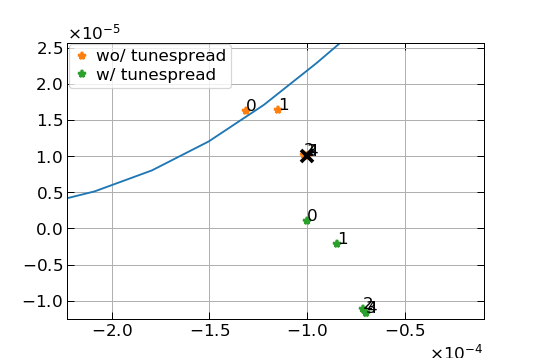

(3.1156307576598005e-05-1.5238723253181536e-05j)
(3.0456393178085258e-05-1.96897096399427e-05j)
Original mode = (-1.00e-04,1.00e-05)
Damped mode   = (-6.98e-05,-1.17e-05)


<IPython.core.display.Javascript object>


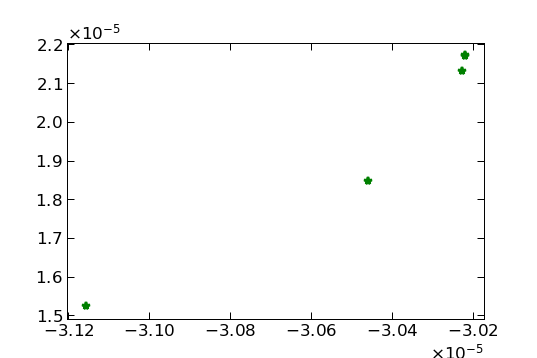

In [60]:
plt.figure()
plt.grid(True)
plt.plot(cohDQs.real,cohDQs.imag)
# plt.plot(cohDQLine.real,cohDQLine.imag,'1r')
# plt.plot(dQ0*np.ones_like(freeGRs),freeGRs,'2b')

for i, X in enumerate([wjs,Wjs]):
    plt.plot(np.real(X),np.imag(X),'*',label=['wo/ tunespread','w/ tunespread'][i])
    for i in range(len(wjs)):
        plt.annotate(i,xy=(X[i].real,X[i].imag))
plt.plot(wj.real,wj.imag,'kx',ms=10,mew=3)
plt.legend(loc=0)
print(Wjs[0]-wjs[0])
print(np.mean(Wjs-wjs))
print('Original mode = (%.2e,%.2e)'%(np.real(wj),np.imag(wj)))
print('Damped mode   = (%.2e,%.2e)'%(np.real(Wji),np.imag(Wji)))
    
plt.figure()
# plt.plot(np.abs(np.array(wjs)-wj),'r',label='err')
# plt.plot(np.real(wjs),np.imag(wjs),'r*')
# plt.plot(np.real(Wjs),np.imag(Wjs),'b*')
plt.plot((wjs-Wjs).real,(wjs-Wjs).imag,'g*')

0.8e-5j  : (1.9273962556529345e-05-6.548423906934872e-06j)
1.8e-5j  : (2.0540569897187496e-05-7.390414497536355e-06j)
2.8e-5j  : (2.17671852698808e-05-8.04750996299532e-06j)
above x 2: (2.786167559443864e-05-2.208718753094121e-06j)

In [103]:
# Impact of integrator_epsilon
nQ=100

freeQs = get_tune_range(detuning,margin=0e-5, n_samples=nQ)
cohDQss =[]
integrator_epsilons = (1+np.arange(5))*2e-6  *ax/1e-4

for i in range(3):
    integrator_epsilon=integrator_epsilons[i]
    integrator = Integrator(distribution, detuning, maxJ=18,epsilon=integrator_epsilon)
    cohDQs = np.zeros((len(freeQs)), dtype='complex')
    for k, q in enumerate(freeQs):
        cohDQs[k] = integrator.integrate(q) #- 1j*integrator_epsilon
    cohDQss.append(cohDQs)
    


<IPython.core.display.Javascript object>


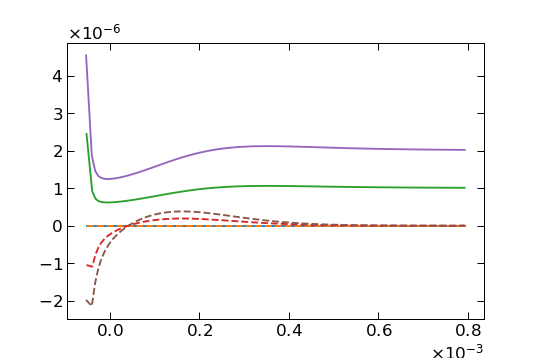

<IPython.core.display.Javascript object>


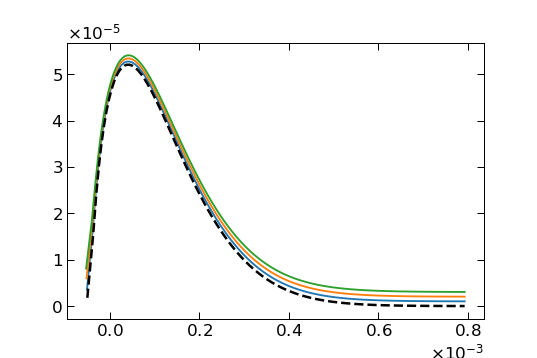

<IPython.core.display.Javascript object>


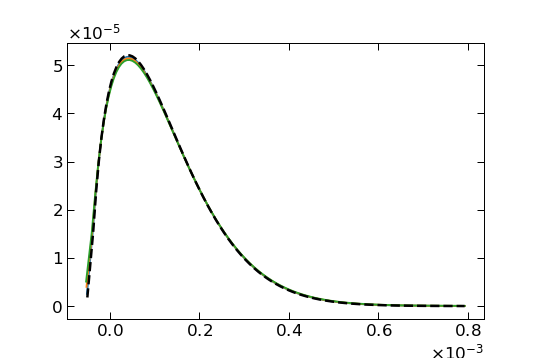

<IPython.core.display.Javascript object>


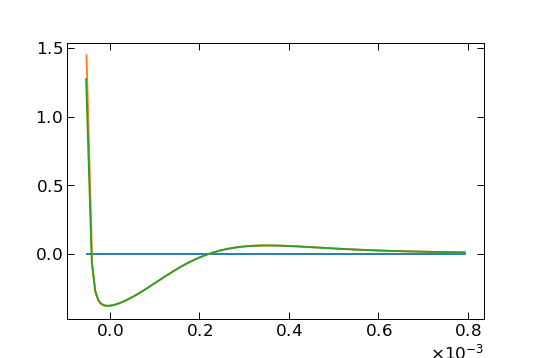

<IPython.core.display.Javascript object>


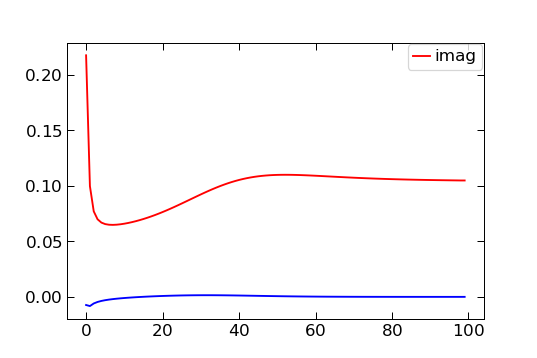

<IPython.core.display.Javascript object>


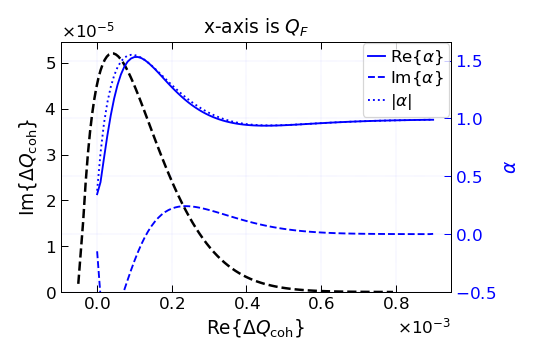

In [105]:
fig0=plt.figure()
ax0=fig0.gca()
fig1=plt.figure()
ax1=fig1.gca()
fig2=plt.figure()
ax2=fig2.gca()
fig3=plt.figure()
ax3=fig3.gca()
for i in range(3):
    integrator_epsilon=integrator_epsilons[i]
    delta_epsilon = integrator_epsilon-integrator_epsilons[0] 
    ax1.plot(cohDQss[i].real,cohDQss[i].imag,label=i)
    ax0.plot(cohDQss[i].real,cohDQss[i].imag-cohDQss[0].imag,label=i)
    ax0.plot(cohDQss[i].real,cohDQss[i].real-cohDQss[0].real,'--',label=i)
    ax2.plot(cohDQss[i].real,cohDQss[i].imag-integrator_epsilon,label=i)
    ax3.plot(cohDQss[i].real,((cohDQss[i].imag-cohDQss[0].imag)
                             -(delta_epsilon))/(delta_epsilon+1e-9),label=i)
    
dCohdTau = (cohDQss[2]-cohDQss[1])/(integrator_epsilons[2]-integrator_epsilons[1])
best = cohDQss[1] + dCohdTau*(-integrator_epsilons[1])
ax1.plot(best.real,best.imag,'--k',lw=2)
ax2.plot(best.real,best.imag,'--k',lw=2)

plt.figure()
plt.plot(dCohdTau.real  / np.std(best.real)*integrator_epsilons[1],'b')
plt.plot(dCohdTau.imag / np.std(best.imag)*integrator_epsilons[1],'r',label='imag')
plt.legend()


frev = 11.245e3
# bestomega = 2*np.pi*frev*best
bestomega = best
fig=plt.figure()
axl = fig.gca()
plt.plot(bestomega.real,bestomega.imag,'--k',lw=2)
axr = axl.twinx()


alpha = 1j*(integrator_epsilons[1]-integrator_epsilons[0])/(cohDQss[1]-cohDQss[0])
# axr.plot(bestomega.real,alpha.real,'b',label=r'$\mathrm{Re}\{\alpha\}$')
# axr.plot(bestomega.real,alpha.imag,'b--',label=r'$\mathrm{Im}\{\alpha\}$')
# axr.plot(bestomega.real,np.abs(alpha),'b:',label=r'$|\alpha|$')
# plt.title(r'x-axis is $\mathrm{Re}\{\Delta Q_\mathrm{coh}\}$')
axr.plot(freeQs-Qx,alpha.real,'b',label=r'$\mathrm{Re}\{\alpha\}$')
axr.plot(freeQs-Qx,alpha.imag,'b--',label=r'$\mathrm{Im}\{\alpha\}$')
axr.plot(freeQs-Qx,np.abs(alpha),'b:',label=r'$|\alpha|$')
plt.title(r'x-axis is $Q_F$')
axr.tick_params('y', colors='b')
# axl.set_xlim(-1.2e-3,1.2e-3)
axl.set_xlabel(r'$\mathrm{Re}\{\Delta Q_\mathrm{coh}\}$')
axl.set_ylabel(r'$\mathrm{Im}\{\Delta Q_\mathrm{coh}\}$')
axr.set_ylabel(r'$\alpha$',color='b')
axr.grid(True,color='b',lw=0.1,ls=':')
axl.grid(True,color='b',axis='x',lw=0.1,ls=':')
# axl.plot([-1e-2,1e-2],[0,0],'k',lw=0.2,ls=':')
axl.set_ylim(bottom=0) ; axr.set_ylim(bottom=-0.5)

axr.legend()
fig.tight_layout()
fig.savefig(pltstorage+"TaylorBigOmega_alpha.pdf")
fig.savefig(pltstorage+"TaylorBigOmega_alpha.eps")



# Finding a_thresh

(-0.0036869731382529808+0.0003141592653589793j)
0.001j


<IPython.core.display.Javascript object>


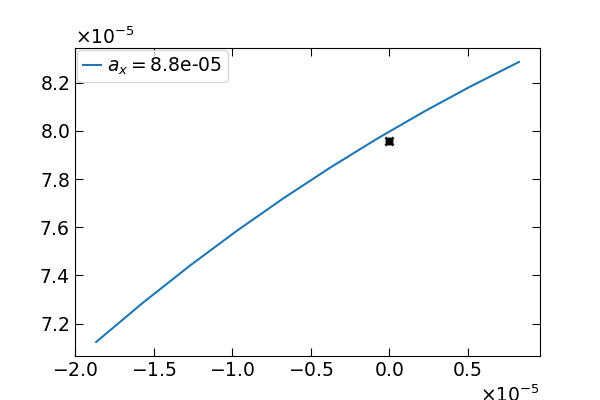

In [111]:
# Impact of integrator_epsilon
#mode 0
wjBB = -2.737e-4 +3.60452e-5j
wjCO = -2.20e-04+ 1j*3.59e-05
axs = [9.64e-5,10e-5,11e-5]

# mode 1
wjBB = -8.42630653e-05+4.26645271e-06j
wjCO = 8.67e-6  + 3.5e-6j
axs = [.4e-5,2e-5,2.4e-5]

#ws2
wjBB = -1.70118759e-04+7.71589202e-06j
wjCO = 1.13e-4 + 6.1358e-6j
axs = [5e-5,2e-5,2.4e-5]

#gwake 1
wjBB = wjCO = -2.934e-4+2.5e-5j
print(wjBB*4*np.pi)
axs = [5e-5,1e-4]

#gwake 2
wjBB = wjCO = 0+1e-3j/(4*np.pi)
print(wjBB*4*np.pi)
axs = [.88e-4]


# wmode__DQ = [wj]
# wmodeDipm = [1,]
# wmodeLDDQ = [0]

Qx = 0.31
distribution = Gaussian()
nQ=10

plt.figure()
plt.plot(wjBB.real,wjBB.imag,'kx')
plt.plot(wjCO.real,wjCO.imag,'k+')

for i in range(len(axs)):
    ax = axs[i]
    bx = -.7*ax *0
    integrator_epsilon=1e-6 *ax/1e-4 * 2

    detuning = LinearDetuning(Qx,ax,bx)
    integrator1 = Integrator(distribution, detuning, maxJ=18,epsilon=integrator_epsilon)
    integrator2 = Integrator(distribution, detuning, maxJ=18,epsilon=integrator_epsilon*2)
    
    freeQs = get_tune_range(detuning,margin=2e-5, n_samples=nQ)
    freeQs = Qx+ ax*np.linspace(1,+1.5,nQ)
    cohDQs = np.zeros((len(freeQs)), dtype='complex')
    for k, q in enumerate(freeQs):
        cohDQs[k] = 2*integrator1.integrate(q)-integrator2.integrate(q)
        
    plt.plot(cohDQs.real,cohDQs.imag,label=r'$a_x=$%.1e'%ax)
    
plt.legend(loc=0)

<IPython.core.display.Javascript object>


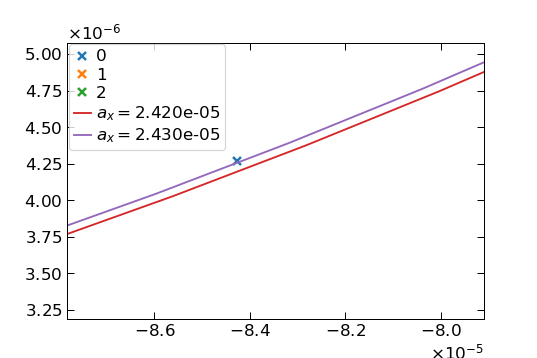

In [217]:
# Impact of integrator_epsilon
#mode 0

# mode 1
wjs = [-8.42630653e-05+4.26645271e-06j, -6.45560213e-05+1.44627487e-06j,-4.02684229e-05+2.20672406e-06j]
axs = [2.42e-5,2.43e-5,1.2e-5]


# wmode__DQ = [wj]
# wmodeDipm = [1,]
# wmodeLDDQ = [0]

Qx = 0.31
distribution = Gaussian()
nQ=20

plt.figure()
for i,wj in enumerate(wjs):
    plt.plot(wj.real,wj.imag,'x',label=i)


for i in range(2):
    ax = axs[i]
    bx = -.7*ax
    integrator_epsilon=1e-6 *ax/1e-4 * 2

    detuning = LinearDetuning(Qx,ax,bx)
    integrator = TrapzIntegrator(distribution, detuning, maxJ=18,n_steps=1000)

    freeQs = get_tune_range(detuning,margin=2e-5, n_samples=nQ)
    freeQs = Qx+ ax*np.linspace(-4,-2,nQ)
    cohDQs = np.zeros((len(freeQs)), dtype='complex')
    for k, q in enumerate(freeQs):
        cohDQs[k] = integrator.integrate(q,epsilon=integrator_epsilon) - 1j*integrator_epsilon
        
    plt.plot(cohDQs.real,cohDQs.imag,label=r'$a_x=$%.3e'%ax)
    
plt.legend(loc=0)

# Comparison of diffusion coefficients

In [262]:
from PyRADISE.Coefficients import DiffCoeff3
from PyRADISE.Coefficients import calc_LandauDampedOneMode as onemode
Qx = 0.31
ax = 1.4e-3
bx = -0.7*ax
f_rev = 1 #11.2455e3
Qs = 0.002





sigma_ibs=0
D_ibs = f_rev*sigma_ibs**2/2
sigma_k = 3e-4/np.sqrt(1e5)
sigma_k = 1e-4
Pnoise = f_rev*sigma_k**2
D_k = f_rev*sigma_k**2/2




nQ = 60
integrator_epsilon=1e-6 *ax/1e-4 *[1,4][bx==0]


wmode__DQ = [(7e-4+3e-4j)/(4*np.pi)]
wmode__DQ = [(-2.934e-4+2.5e-5j)*10]
# wmode__DQ = [5e-5+1j*2.86e-5]
# wmode__DQ = [14e-5+1j*0.3e-5]
wmodeQ0 = [Qx]

# PySSD
distribution = Gaussian()
detuning = LinearDetuning(Qx,ax,bx)
integrator1 = Integrator(distribution, detuning, maxJ=18,epsilon = integrator_epsilon)
integrator2 = Integrator(distribution, detuning, maxJ=18,epsilon = integrator_epsilon*2)


J = np.linspace(-4,0,100)
incoQ = Qx*0 + detuning(J,0)

self= empty()
self.M = empty()
self.Q = empty()
self.M.Q=detuning
self.M.Q.Q0x = Qx
self.M.wmode__DQx = np.array([wmode__DQ]) if np.shape(wmode__DQ)==() else np.array(wmode__DQ)
self.M.wmodeLdDQx = np.zeros_like(self.M.wmode__DQx)
self.M.wmodeDipmx = np.array([wmodeDipm]) if np.shape(wmodeDipm)==() else np.array(wmodeDipm)
self.integrator_epsilon=integrator_epsilon


flagFindalpha=0
# calc_LandauDampedAllModes(self,plane=0,debug=0,tol=1e-4,relstep=[.5,.05],flagFindalpha=flagFindalpha)
# wmodeLdDQ = [Wji]
# print(Wji)


# wmodeLdDQ_alpham11 ,cnt,err= onemode(self,integrator,Qx,wmode__DQ[0],flagFindalpha=[-1,1])
# print(wmodeLdDQ_alpham11,cnt)

wmodeLdDQ_alpha11 ,cnt,err= calc_CapitalOmega(distribution,detuning,integrator_epsilon,Qx,wmode__DQ[0],flagFindalpha=[1,1])
print(wmodeLdDQ_alpha11,Qx+wmodeLdDQ_alpha11,cnt)
# wmodeLdDQ_alpha10 ,cnt,err= calc_CapitalOmega(distribution,detuning,integrator_epsilon,Qx,wmode__DQ[0],flagFindalpha=[1,0])
# print(wmodeLdDQ_alpha10,cnt)
# wmodeLdDQ_alpha00 ,cnt,err= calc_CapitalOmega(distribution,detuning,integrator_epsilon,Qx,wmode__DQ[0],flagFindalpha=[0,0])
# print(wmodeLdDQ_alpha00,cnt)

# def calc_LandauDampedOneMode(self,integrator,Q0,modeDQ,relstep=[1,.05],tol=1e-4,flagFindalpha=1,debug=0):
#     global Wjs, wjs, Wji
#     return dampDQ
# def calc_LandauDampedOneMode(self,integrator,Q0,modeDQ,relstep=[.5,.05],tol=1e-4,flagFindalpha=[1,1],debug=0):
print(np.abs(1.44e+00 +5.51e-02j)**1)

R_D = (-pi2*np.imag(wmodeLdDQ_alpha11))**2.5 / (ax*sigma_k*1*np.abs(wmode__DQ[0])*pi2)
print('R_D',R_D)#,np.imag(wmodeLdDQ_alpha11) / (ax*sigma_k*1*np.abs(wmode__DQ[0])*pi2))
print('|g|',np.abs(wmode__DQ[0]*4*np.pi))

Found alpha!=1, alpha=9.45e-01 -2.06e-01j |  dampDQ = -2.09e-03 -3.278e-04j -> -2.15e-03 -3.097e-04j
(-0.0021544102193466765-0.00030973319338682687j) (0.3078455897806533-0.00030973319338682687j) 5
1.4410537845618392
R_D 64.50303586910412
|g| 0.03700333358794843


/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:78: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:79: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:80: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


In [263]:
# lebedev
freeQs = J*ax + Qx
cohDQs = np.zeros((len(freeQs)), dtype='complex')
for k, q in enumerate(freeQs):
    cohDQs[k] = (2*integrator1.integrate(q) 
                  -integrator2.integrate(q) )

R = -1/cohDQs
dQ = wmode__DQ

eps =  1+ dQ*R
Dl = D_k *1/np.abs(eps)**2 




print(R)
print(dQ)

In [1]:
alpha=1.25e+00 +2.12e-01j
alpha=9.24e-01 -1.82e-01j
alpha=9.45e-01 -2.06e-01j 

absalpha = abs(alpha)
print(absalpha)
plt.figure()
plt.title("Stability diagram and mode")
plt.plot(cohDQs.real,cohDQs.imag)
plt.plot(wmode__DQ[0].real,wmode__DQ[0].imag,'rx')
plt.tight_layout()

plt.figure()
plt.title("Diffusion coefficient")
plt.plot(J,eps)
plt.plot(J,Dl,'r')
plt.xlabel('J')
plt.tight_layout()


Response = R/eps

dipm=1
dampDQ = wmodeLdDQ_alpha11
modeQ0 = wmodeQ0[0]    
modeDQ = wmode__DQ[0]
newQ2  =  (modeQ0+dampDQ.real)**2 - (dampDQ.imag)**2
newQIR =  (modeQ0+dampDQ.real)*dampDQ.imag
# absModeDQ2 = np.abs(modeDQ)**2
# B = 1/(1 + (newQ2 - (incoQ)**2)**2/(4*(newQIR)**2))
# USHO_response = np.sqrt(absModeDQ2 * B / (4*(newQIR)**2)) # dipm*sigma_k 
USHO_response = 1 / np.sqrt( (newQ2 - (incoQ)**2)**2 + 4*(newQIR)**2 )

plt.figure()
plt.title("Response")
plt.plot(freeQs, np.abs(Response),label='LEB')
plt.plot(freeQs, USHO_response ,label='SVF')
plt.plot(freeQs, USHO_response*absalpha ,label=r'SVF*$\alpha$')
plt.legend(loc=0)

print( np.abs(modeDQ), np.abs(dampDQ))

0.967192328340129


NameError: name 'plt' is not defined

Correction of mode 0: 1+(4.5e-03)


<IPython.core.display.Javascript object>


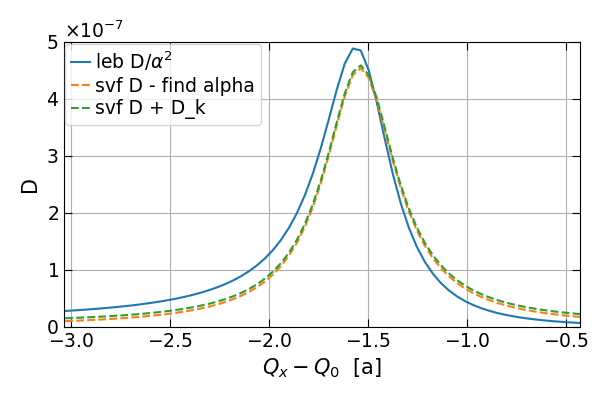

/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


In [265]:
# alpha=1.37e+00 -4.99e-01j
# absalpha = np.abs(alpha)

D11,err = DiffCoeff3(J,D_ibs,D_k,[1],[0],Qs,incoQ,wmodeQ0,wmode__DQ,[1] ,[wmodeLdDQ_alpha11])
# D00,err = DiffCoeff3(J,D_ibs,D_k,[1],[0],Qs,incoQ,wmodeQ0,wmode__DQ,[1] ,[wmodeLdDQ_alpha00])
# Dm11,err = DiffCoeff3(J,D_ibs,D_k,[1],[0],Qs,incoQ,wmodeQ0,wmode__DQ,[1],[wmodeLdDQ_alpham11])
# D10,err = DiffCoeff3(J,D_ibs,D_k,[1],[0],Qs,incoQ,wmodeQ0,wmode__DQ,[1] ,[wmodeLdDQ_alpha10])


lss = ['-','--','-.',':']
plt.figure()
plt.plot(J,Dl/absalpha**2,label=r'leb D/$\alpha^2$')
# plt.plot(J,D_k*0+D00/J,lss[0],label='svf D - alpha=1')
# D0amp = np.max(D00)
# plt.plot(J,np.sqrt(D00/D0amp)*D0amp/J,lss[0],label='svf D - alpha=1')
# plt.plot(J,D_k*0+D00,label='svf JD - alpha=1')
plt.plot(J,D_k*0+D11/J,lss[1],label='svf D - find alpha')
plt.plot(J,D_k*1+D11/J,lss[1],label='svf D + D_k')
# plt.plot(J,D_k*0+D11,lss[2],label='svf JD - find alpha')
# plt.plot(J,Dm11/J,label='svf - find -alpha')
# plt.plot(J,D_k*0+D10/J,'--',label='svf - alpha=real')


plt.legend(loc=0)
plt.xlabel(r'$Q_x-Q_0$  [a]')
plt.ylabel('D')
# plt.xlim(2.8,3.1)
plt.ylim(bottom=0)
plt.grid(True)
plt.tight_layout()


# Results from COMBI

## Using a_thresh ~ 1e-4 

In [184]:
# Input
a0 = 1e-4
b0 = -0.7*a0

scales = np.arange(0,2.01,0.2)
for scale in scales:
    print("3 13 %.5f %.6f %.5f %.6f "%(a0*scale,b0*scale,a0*scale,b0*scale))

3 13 0.00000 -0.000000 0.00000 -0.000000 
3 13 0.00002 -0.000014 0.00002 -0.000014 
3 13 0.00004 -0.000028 0.00004 -0.000028 
3 13 0.00006 -0.000042 0.00006 -0.000042 
3 13 0.00008 -0.000056 0.00008 -0.000056 
3 13 0.00010 -0.000070 0.00010 -0.000070 
3 13 0.00012 -0.000084 0.00012 -0.000084 
3 13 0.00014 -0.000098 0.00014 -0.000098 
3 13 0.00016 -0.000112 0.00016 -0.000112 
3 13 0.00018 -0.000126 0.00018 -0.000126 
3 13 0.00020 -0.000140 0.00020 -0.000140 


In [185]:
#Np = 5e6
N=7
data = np.zeros((N,3))
data[:,0] = [250,500,750,1000,1001,1002,2000]
data[0,1:] = [-1.87e-04, 3.59e-05 ]
data[1,1:] = [-2.07e-04, 3.57e-05 ]
data[2,1:] = [-2.13e-04, 3.54e-05]
data[3,1:] = [-2.18e-04, 3.59e-05 ]
data[4,1:] = [-2.18e-04, 3.59e-05 ]
data[5,1:] = [ -2.18e-04, 3.59e-05 ]
data[6,1:] = [-2.14e-04, 3.58e-05 ]

combi_0 = np.empty((N,3))
# combi_0[:,0] = np.arange(0,2.1e-4,2e-5)
combi_0[0,1:] = [ -2.18e-04, 3.59e-05 ] 
combi_0[1,1:] = [-1.95e-04, 3.55e-05 ]
combi_0[2,1:] = [ -1.79e-04, 3.46e-05 ]
combi_0[3,1:] = [ -1.69e-04, 2.89e-05 ]
combi_0[4,1:] = [ -1.61e-04, 2.04e-05 ]
combi_0[5,1:] = [ -1.53e-04, 1.01e-05 ] #

#Np = 5e6
N=7
data = np.zeros((N,3))
data[:,0] = [250,500,750,1000,1001,1002,2000]
data[0,1:] = [-1.87e-04, 3.59e-05 ]
data[1,1:] = [-2.07e-04, 3.57e-05 ]
data[2,1:] = [-2.13e-04, 3.54e-05]
data[3,1:] = [-2.18e-04, 3.59e-05 ]
data[4,1:] = [-2.18e-04, 3.59e-05 ]
data[5,1:] = [ -2.18e-04, 3.59e-05 ]
data[6,1:] = [-2.14e-04, 3.58e-05 ]

N=11
combi_0 = np.empty((N,3))
combi_0[:,0] = np.arange(0,2.1e-4,2e-5)
combi_0[0,1:] = [ -2.2e-04, 3.59e-05 ] 
combi_0[1,1:] = [-1.95e-04, 3.55e-05 ]
combi_0[2,1:] = [ -1.79e-04, 3.46e-05 ]
combi_0[3,1:] = [ -1.69e-04, 2.89e-05 ]
combi_0[4,1:] = [ -1.61e-04, 2.04e-05 ]
combi_0[5,1:] = [ -1.53e-04, 0 ] #+- 1e-5 digging!
combi_0[6,1:] = [ -1.47e-04, np.nan ] 
combi_0[7:,1:]=np.nan

# combi_0[7,1:] = 
# combi_0[8,1:] = 

combi_0 = np.empty((N,4))
combi_0[:]=np.nan
combi_0[:,3] = 0
combi_0[0] = [0,-2.20e-04 , 3.59e-05 , 4.41e-08]
combi_0[1] = [2e-5 , -1.95e-04 , 3.66e-05 , 6.98e-07] #x=0.005, [2000,3000
combi_0[2] = [4e-5 , -1.79e-04 , 3.45e-05 , 9.51e-07] #x=0.005, [2000,3000
combi_0[3] = [6e-5 , -1.69e-04 , 2.75e-05 , 2.74e-07] #x=0.005, [2000,3000
combi_0[4] = [8e-5 , -1.61e-04 , 1.62e-05 , 2.69e-06] #x=0.005, [2000,3000
# combi_0[5] = [1e-5,  -1.53e-4, 0, 0]


N=11
combi_4 = np.empty((N,3))
combi_4[:,0] = np.arange(0,2.1e-4,2e-5)
combi_4[0] = [0e-5, np.nan,0] 
combi_4[1] = [2e-5, -1.96e-04, 3.51e-05 ]
combi_4[2] = [4e-5, -1.79e-04, 3.32e-05 ]
combi_4[3] = [6e-5, -1.68e-04, 2.83e-05 ] 
combi_4[4] = [8e-5, -1.60e-04, 2.06e-05 ] 
combi_4[5] = [10e-5,-1.52e-04, -3.95e-06 ] #+-6e-6  unstable [ -1.52e-04, 1.01e-05 ]
combi_4[6] = [12e-5,-1.43e-04, -1.72e-05 ] #+- 5e-6 unstable [ -1.43e-04, 1.89e-05 ]
combi_4[7] = [14e-5,-1.31e-04, -3.25e-05 ] #+- 4e-5 unstable [ -1.31e-04, 1.58e-05 ] 
combi_4[8] = [16e-5, -1.23e-04, -5.37e-05] #+- 8e-6 
combi_4[9] = [18e-5,-1.30e-04, -6.97e-05]  #+- 5e-6
combi_4[10]= [2e-4,-1.03e-04, -9.00e-05]   #+- 5e-6

combi_4 = np.empty((N,4))
combi_4[0] = [0e-5,  -2.20e-04 , 3.58e-05 , 6.34e-07]
combi_4[1] = [ 2e-5 , -1.96e-04 , 3.54e-05 , 1.78e-06] #1500, [1000,2000
combi_4[2] = [ 4e-5 , -1.79e-04 , 3.19e-05 , 3.26e-06] #1000, [1000,2000
combi_4[3] = [ 6e-5 , -1.68e-04 , 2.71e-05 , 2.95e-06] #1000, [1000,2000
combi_4[4] = [ 8e-5 , -1.60e-04 , 9.40e-06 , 5.18e-06] # 0, [1000,2000
combi_4[5] = [10e-5 , -1.52e-04 , -6.19e-06 , 4.35e-06]# 0, [1000,1500
combi_4[6] = [12e-5 , -1.43e-04 , -1.94e-05 , 4.04e-06]# 0, [1000,1500
combi_4[7] = [14e-5 , -1.30e-04 , -3.57e-05 , 4.30e-06]# 0, [1000,1500
combi_4[8] = [16e-5 , -1.20e-04 , -5.23e-05 , 6.34e-06]# 0, [1000,1500
combi_4[9] = [18e-5 , -1.23e-04 , -6.88e-05 , 6.36e-06]# 0, [1000,1500
combi_4[10]= [20e-5 , -1.02e-04 , -8.77e-05 , 5.48e-06] # 0, [1000,1500

N=11
combi_2 = np.empty((N,3))
combi_2[0] = [0,np.nan,np.nan]
combi_2[1] = [2e-5, -1.99e-04, 3.52e-05 ] 
combi_2[2] = [4e-5, -1.79e-04, 3.34e-05 ] 
combi_2[3] = [6e-5, -1.68e-04, 2.87e-05 ] 
combi_2[4] = [8e-5, -1.60e-04, 2.09e-05 ] 
combi_2[5] = [10e-5,-1.53e-04, -6.07e-06 ] # unstable [ -1.53e-04, 1.06e-05 ]
combi_2[6] = [12e-5,-1.40e-04, -2.03e-05 ] # +-6e-6  # unstable [ -1.43e-04, 1.41e-05 ] 
combi_2[7] = [14e-5,-1.31e-04, -3.61e-05 ] # unstable [ -1.29e-04, 9.71e-06 ] 
combi_2[8] = [16e-5,-1.15e-04, -5.33e-05 ] #
combi_2[9] = [18e-5,-8.95e-05 , -6.52e-05 ] #+-4e-6
combi_2[10]= [20e-5,-8.95e-05, -1.05e-04 ] #+-1e-5

combi_2 = np.empty((N,4))
combi_2[0] = [0e-5, -2.20e-04, 3.57e-05 ,  7.10e-07] 
combi_2[1] = [2e-5 , -1.99e-04 , 3.58e-05 , 1.09e-06] #1500, [1000,2000
combi_2[2] = [4e-5 , -1.79e-04 , 3.12e-05 , 3.73e-06] #1000, [1000,2000
combi_2[3] = [6e-5 , -1.68e-04 , 2.66e-05 , 3.55e-06] #1000, [1000,2000
combi_2[4] = [8e-5 , -1.60e-04 , 1.17e-05 , 4.20e-06] #   0, [1000,2000
combi_2[5] = [10e-5 , -1.53e-04 , -7.11e-06 , 2.68e-06] # 0, [1000,1500
combi_2[6] = [12e-5 , -1.4e-04 , -2.36e-05 , 6.89e-06] # 0, [1000,1500
combi_2[7] = [14e-5 , -1.31e-04 , -3.36e-05 , 2.84e-06] # 0, [1000,1500
combi_2[8] = [16e-5 , -1.15e-04 , -5.11e-05 , 5.43e-06] # 0, [1000,1500
combi_2[9] = [18e-5 ,-8.95e-05 , -6.56e-05 , 1.87e-06] # 0, [1000,1500
combi_2[10]= [20e-5 , -8.95e-05 , -1.07e-04 , 8.71e-06] # 0, [1000,1500


In [186]:
#Theory alpha=1
N=11
theory_fa0 = np.zeros((N,3))
theory_fa0[:,0] = np.arange(0,2.1e-4,2e-5)

# theory_fa0[1] = [2.00e-05 , -1.96e-04 , 3.52e-05]
# theory_fa0[2] = [4.00e-05 , -1.82e-04 , 3.22e-05]
# theory_fa0[3] = [6.00e-05 , -1.73e-04 , 2.42e-05]
# theory_fa0[4] = [8.00e-05 , -1.66e-04 , 1.17e-05]
# theory_fa0[5] = [1.00e-04 , -1.57e-04 , -3.60e-06]
# theory_fa0[6] = [1.20e-04 , -1.45e-04 , -2.12e-05]
# theory_fa0[7] = [1.40e-04 , -1.32e-04 , -3.92e-05]
# theory_fa0[8] = [1.60e-04 , -1.18e-04 , -5.71e-05]
# theory_fa0[9] = [1.80e-04 , -1.04e-04 , -7.48e-05]
# theory_fa0[10] = [2.00e-04 , -8.92e-05 , -9.24e-05]
theory_fa0[0] = [0.00e+00 , -2.2e-04 , 3.59e-05]
theory_fa0[1] = [2.00e-05 , -1.98e-04 , 3.59e-05]
theory_fa0[2] = [4.00e-05 , -1.85e-04 , 3.46e-05]
theory_fa0[3] = [6.00e-05 , -1.78e-04 , 2.69e-05]
theory_fa0[4] = [8.00e-05 , -1.69e-04 , 1.33e-05]
theory_fa0[5] = [1.00e-04 , -1.59e-04 , -3.17e-06]
theory_fa0[6] = [1.20e-04 , -1.47e-04 , -2.08e-05]
theory_fa0[7] = [1.40e-04 , -1.34e-04 , -3.87e-05]
theory_fa0[8] = [1.60e-04 , -1.20e-04 , -5.67e-05]
theory_fa0[9] = [1.80e-04 , -1.06e-04 , -7.45e-05]
theory_fa0[10] = [2.00e-04 , -9.13e-05 , -9.21e-05]

#Theory alpha=x
N=11
theory_fa1 = np.zeros((N,3))
theory_fa1[:,0] = np.arange(0,2.1e-4,2e-5)
# theory_fa1[0] = [0.00e+00 , -2.18e-04 , 3.59e-05]
# theory_fa1[1] = [2.00e-05 , -1.96e-04 , 3.52e-05]
# theory_fa1[2] = [4.00e-05 , -1.84e-04 , 3.19e-05]
# theory_fa1[3] = [6.00e-05 , -1.75e-04 , 2.41e-05]
# theory_fa1[4] = [8.00e-05 , -1.67e-04 , 1.21e-05]
# theory_fa1[5] = [1.00e-04 , -1.60e-04 , -2.97e-06]
# theory_fa1[6] = [1.20e-04 , -1.52e-04 , -2.01e-05]
# theory_fa1[7] = [1.40e-04 , -1.41e-04 , -3.88e-05]
# theory_fa1[8] = [1.60e-04 , -1.31e-04 , -5.75e-05]
# theory_fa1[9] = [1.80e-04 , -1.23e-04 , -7.57e-05]
# theory_fa1[10] = [2.00e-04 , -1.09e-04 , -9.42e-05]
theory_fa1[0] = [0.00e+00 , -2.2e-04 , 3.59e-05]
theory_fa1[1] = [2.00e-05 , -1.98e-04 , 3.52e-05]
theory_fa1[2] = [4.00e-05 , -1.82e-04 , 3.19e-05]
theory_fa1[3] = [6.00e-05 , -1.73e-04 , 2.39e-05]
theory_fa1[4] = [8.00e-05 , -1.65e-04 , 1.18e-05]
theory_fa1[5] = [1.00e-04 , -1.58e-04 , -3.38e-06]
theory_fa1[6] = [1.20e-04 , -1.50e-04 , -2.05e-05]
theory_fa1[7] = [1.40e-04 , -1.43e-04 , -3.83e-05]
theory_fa1[8] = [1.60e-04 , -1.33e-04 , -5.70e-05]
theory_fa1[9] = [1.80e-04 , -1.20e-04 , -7.61e-05]
theory_fa1[10] = [2.00e-04 , -1.12e-04 , -9.39e-05]




## Using a_thresh = 9.64e-5

In [187]:
import os
import harpy.harmonic_analysis as harpy
pi2 = np.pi*2
gamma = 6500/0.938272
beta = 0.4
emitX=2e-6
sigx = np.sqrt(beta*emitX/gamma)
sigp = sigx/beta
def parseBeamParameter(fileName,filter=1,lower=0,upper=-1,nparam=18):
    data = [];
    for i in np.arange(nparam):
        data.append([]);
    coreName, extension = os.path.splitext(fileName)
    if '.gz' in extension:
        myFile = gzip.open(fileName,'r');
        gzipped = True;
    else:
        myFile = open(fileName,'r');
        gzipped = False;
    count = 0;
    for line in myFile.readlines():
        if gzipped:
            # row = line.decode('latin-1').rstrip().split(' ');
            row = line.rstrip().split(' ');
        else:
            row = line.rstrip().split(' ');
        isLower = 1;
        if upper != -1:
            if count>=upper:
                isLower = 0;
        if count%filter ==0 and count>=lower and isLower:
            if len(row)==nparam:
                for i in np.arange(nparam):
                    data[i].append(float(row[i]));
            else:
                print("ERROR at line",count,':',row,'Skipping line');
        count=count+1;
    myFile.close();
    return data;

# Combi
sep0 = 0.01
a_thr = 9.64e-5
folder1 = '/home/sfuruset/hdd/05_Combi_related/01_output/Omega/'
folder = r'w0.5_Qp-5_N0_%.2fto0.2'%sep0+'_a%.2e_g0_Np5e6_Ns1000'


folders =[]
labels = []

for i in range(21):
    a = i/10*a_thr
    folders+=[folder%a]
#            labels+=[r'$a=%.1f\cdot10^{-5}$'%(a*1e5)]
    labels+=[r'$a=%.1f\cdot a_\mathrm{thr}$'%(i/10)]
    

print('combi_thr_%d = np.empty((N,5))'%(sep0*100))

for iname,name in enumerate(folders[:21]):
    try: 
        data = parseBeamParameter(folder1+name+"/B1b1.bparam"); 
        T = np.arange(np.size(data[0]))           
    except:
        print('Could not find %s'%(name))
        continue


    Nt=np.size(data[0])
    maxNt = 1*10**4
    stop = 600000
    stop = np.min([Nt,maxNt,stop])    
    X = np.array(data[0][:stop])/sigx
    COM = np.sqrt( ((data[0]/sigx)**2 + (data[4]/sigp)**2)/1.)
    
    
    # Find instability start
    thresh = 0.009
    if COM[-1]>thresh or sep0 >0:
        logCOM = np.log(COM)
        if sep0 == 0 :
            start0 = np.argmax(COM>thresh)
            stop0 = -1
            fit0 = np.polyfit(T[start0:stop0],logCOM[start0:stop0],deg=1)
            # logCOM = fit[1] + T*fit[0]
            start1 = int((np.log(5e-3)-fit0[1])/fit0[0])
            start = min(start1,30000)
            length=3000
            fit = np.polyfit(T[start:start+length],logCOM[start:start+length],deg=1)
#                print(iname,'Start = %d -> %d -> %d'%(start0,start1,start),fit0/pi2,fit/pi2)

            if iname<5:
                lengths = (2+np.arange(6))*(5-iname)*500
            else:
                lengths = (2+np.arange(6))*500 #-1000         
        else:
            start = 500*0 + 125 *0
#             start = 125
            if iname<10:
                start = 125
                lengths = (2+np.arange(6))*max(2,9-iname)*250
            else :
                lengths = (3+np.arange(6))*250 #-1000 

        fits = np.zeros((6,2))
        for il , length in enumerate(lengths):
            fits[il] = np.polyfit(T[start:start+length],logCOM[start:start+length],deg=1)
            #print(start,start+length,fits[il])
        if iname>15:
            fits = fits[:4,:]
            
        grr = np.mean(fits[:,0])/pi2
        std = np.std(fits[:,0])/pi2
#         print(iname, start, 'a = %.2e: %.2e , %.2e'%(a_thr*iname/10,grr,std),fits[:,0]/pi2)

    # Find tune 
    ## Harpy analysis
    Q0 = 0.31  
    start = 10000 * 0
    Qlist = np.empty(5)
    for istop in range(5):
        stop = 10000 *(1+istop)
        X = data[0][start:stop]/sigx #/ COM
        maxNt = 1*10**5
        X = np.pad(X,(0,maxNt-np.size(X)),mode='constant')

        harmonic = harpy.HarmonicAnalysis(X)
        Q,amp = harmonic.laskar_method(6)
    #     print(Q,amp, Q[0])
        Q = np.array(Q)
        Q = Q[np.logical_and(Q>0.1,Q<0.4)]
        Qlist[istop] = Q[0]
    Q = np.mean(Qlist)
    Qstd=np.std(Qlist)
    print("combi_thr_%d[%d] = [%.2e, %.2e, %.2e, %.2e, %.2e] #"%(sep0*100,iname,a_thr*iname/10, Q-Q0, grr,std,Qstd)
         , (Qlist-Q0)*1e6)

combi_thr_1 = np.empty((N,5))
Could not find w0.5_Qp-5_N0_0.01to0.2_a0.00e+00_g0_Np5e6_Ns1000
Could not find w0.5_Qp-5_N0_0.01to0.2_a9.64e-06_g0_Np5e6_Ns1000
Could not find w0.5_Qp-5_N0_0.01to0.2_a1.93e-05_g0_Np5e6_Ns1000
Could not find w0.5_Qp-5_N0_0.01to0.2_a2.89e-05_g0_Np5e6_Ns1000
Could not find w0.5_Qp-5_N0_0.01to0.2_a3.86e-05_g0_Np5e6_Ns1000
Could not find w0.5_Qp-5_N0_0.01to0.2_a4.82e-05_g0_Np5e6_Ns1000
Could not find w0.5_Qp-5_N0_0.01to0.2_a5.78e-05_g0_Np5e6_Ns1000
Could not find w0.5_Qp-5_N0_0.01to0.2_a6.75e-05_g0_Np5e6_Ns1000
Could not find w0.5_Qp-5_N0_0.01to0.2_a7.71e-05_g0_Np5e6_Ns1000
Could not find w0.5_Qp-5_N0_0.01to0.2_a8.68e-05_g0_Np5e6_Ns1000
Could not find w0.5_Qp-5_N0_0.01to0.2_a9.64e-05_g0_Np5e6_Ns1000
Could not find w0.5_Qp-5_N0_0.01to0.2_a1.06e-04_g0_Np5e6_Ns1000
Could not find w0.5_Qp-5_N0_0.01to0.2_a1.16e-04_g0_Np5e6_Ns1000
Could not find w0.5_Qp-5_N0_0.01to0.2_a1.25e-04_g0_Np5e6_Ns1000
Could not find w0.5_Qp-5_N0_0.01to0.2_a1.35e-04_g0_Np5e6_Ns1000
Could not 

In [188]:
# With less turns at higher a
N=21

combi_thr_1 = np.empty((N,5))
combi_thr_1[0] = [0.00e+00, -2.14e-04, 3.59e-05, 4.02e-08, 2.63e-06]
combi_thr_1[1] = [9.64e-06, -2.03e-04, 3.57e-05, 8.82e-08, 8.61e-07]
combi_thr_1[2] = [1.93e-05, -1.93e-04, 3.53e-05, 3.51e-07, 9.36e-07]
combi_thr_1[3] = [2.89e-05, -1.84e-04, 3.47e-05, 3.99e-07, 2.76e-06]
combi_thr_1[4] = [3.86e-05, -1.74e-04, 3.20e-05, 2.28e-06, 2.81e-06]
combi_thr_1[5] = [4.82e-05, -1.76e-04, 2.96e-05, 2.40e-06, 2.94e-06]
combi_thr_1[6] = [5.78e-05, -1.64e-04, 2.39e-05, 4.92e-06, 3.19e-06]
combi_thr_1[7] = [6.75e-05, -1.69e-04, 1.83e-05, 3.30e-06, 1.82e-08]
combi_thr_1[8] = [7.71e-05, -1.62e-04, 1.34e-05, 5.82e-06, 3.60e-06]
combi_thr_1[9] = [8.68e-05, -1.58e-04, 4.23e-06, 1.82e-06, 3.43e-06]
combi_thr_1[10] = [9.64e-05, -1.52e-04, 1.24e-06, 2.82e-06, 3.39e-06]
combi_thr_1[11] = [1.06e-04, -1.52e-04, -1.28e-05, 1.27e-06, 2.98e-06]
combi_thr_1[12] = [1.16e-04, -1.48e-04, -9.75e-06, 2.17e-06, 2.86e-06]
combi_thr_1[13] = [1.25e-04, -1.39e-04, -1.71e-05, 6.96e-06, 2.44e-06]
combi_thr_1[14] = [1.35e-04, -1.37e-04, -2.62e-05, 3.11e-06, 7.31e-06]
combi_thr_1[15] = [1.45e-04, -1.35e-04, -5.11e-05, 7.77e-06, 4.76e-06]
combi_thr_1[16] = [1.54e-04, -1.16e-04, -3.60e-05, 5.74e-07, 8.25e-06]
combi_thr_1[17] = [1.64e-04, -1.24e-04, -5.49e-05, 5.04e-06, 4.14e-06]
combi_thr_1[18] = [1.74e-04, -8.69e-05, -7.02e-05, 7.31e-06, 3.58e-06]
combi_thr_1[19] = [1.83e-04, -9.96e-05, -6.51e-05, 1.78e-06, 2.39e-05]
combi_thr_1[20] = [1.93e-04, -1.14e-04, -1.05e-04, 6.78e-06, 1.06e-05]

combi_thr_2 = np.empty((N,5))
combi_thr_2[0] = [0.00e+00, -2.16e-04, 3.58e-05, 3.17e-08, 1.92e-06]
combi_thr_2[1] = [9.64e-06, -2.05e-04, 3.57e-05, 1.43e-07, 1.42e-07]
combi_thr_2[2] = [1.93e-05, -1.95e-04, 3.53e-05, 2.77e-07, 1.92e-07]
combi_thr_2[3] = [2.89e-05, -1.86e-04, 3.47e-05, 5.23e-07, 2.00e-06]
combi_thr_2[4] = [3.86e-05, -1.76e-04, 3.28e-05, 1.41e-06, 2.04e-06]
combi_thr_2[5] = [4.82e-05, -1.75e-04, 2.98e-05, 2.92e-06, 2.24e-06]
combi_thr_2[6] = [5.78e-05, -1.65e-04, 2.65e-05, 2.55e-06, 2.42e-06]
combi_thr_2[7] = [6.75e-05, -1.66e-04, 1.83e-05, 4.26e-06, 2.67e-06]
combi_thr_2[8] = [7.71e-05, -1.66e-04, 1.40e-05, 3.49e-06, 3.04e-06]
combi_thr_2[9] = [8.68e-05, -1.53e-04, 8.00e-06, 4.33e-06, 3.51e-06]
combi_thr_2[10] = [9.64e-05, -1.52e-04, -6.25e-06, 3.00e-06, 3.41e-06]
combi_thr_2[11] = [1.06e-04, -1.51e-04, -1.21e-05, 2.07e-06, 3.16e-06]
combi_thr_2[12] = [1.16e-04, -1.44e-04, -1.98e-05, 3.09e-06, 4.01e-06]
combi_thr_2[13] = [1.25e-04, -1.42e-04, -2.55e-05, 2.75e-06, 2.65e-06]
combi_thr_2[14] = [1.35e-04, -1.33e-04, -3.41e-05, 3.16e-06, 3.50e-06]
combi_thr_2[15] = [1.45e-04, -1.28e-04, -4.25e-05, 2.44e-06, 7.48e-06]
combi_thr_2[16] = [1.54e-04, -1.28e-04, -4.56e-05, 1.03e-06, 1.07e-06]
combi_thr_2[17] = [1.64e-04, -1.21e-04, -6.83e-05, 2.53e-06, 4.11e-06]
combi_thr_2[18] = [1.74e-04, -1.46e-04, -7.75e-05, 1.69e-06, 4.42e-06]
combi_thr_2[19] = [1.83e-04, -1.16e-04, -7.91e-05, 5.23e-06, 1.27e-05]
combi_thr_2[20] = [1.93e-04, -9.13e-05, -8.57e-05, 5.99e-06, 2.09e-05]

combi_thr_4 = np.empty((N,5))
combi_thr_4[0] = [0.00e+00, -2.20e-04, 3.58e-05, 4.14e-08, 0.00e+00]
combi_thr_4[1] = [9.64e-06, -2.09e-04, 3.56e-05, 1.06e-07, 0.00e+00]
combi_thr_4[2] = [1.93e-05, -1.99e-04, 3.52e-05, 3.09e-07, 0.00e+00]
combi_thr_4[3] = [2.89e-05, -1.90e-04, 3.44e-05, 8.44e-07, 0.00e+00]
combi_thr_4[4] = [3.86e-05, -1.80e-04, 3.27e-05, 1.54e-06, 0.00e+00]
combi_thr_4[5] = [4.82e-05, -1.71e-04, 2.96e-05, 2.86e-06, 0.00e+00]
combi_thr_4[6] = [5.78e-05, -1.70e-04, 2.50e-05, 3.63e-06, 0.00e+00]
combi_thr_4[7] = [6.75e-05, -1.64e-04, 1.83e-05, 3.07e-06, 1.80e-06]
combi_thr_4[8] = [7.71e-05, -1.64e-04, 1.27e-05, 3.52e-06, 2.05e-06]
combi_thr_4[9] = [8.68e-05, -1.54e-04, 6.29e-06, 3.98e-06, 2.60e-06]
combi_thr_4[10] = [9.64e-05, -1.56e-04, -4.63e-06, 2.51e-06, 2.80e-06]
combi_thr_4[11] = [1.06e-04, -1.43e-04, -1.12e-05, 2.37e-06, 3.65e-06]
combi_thr_4[12] = [1.16e-04, -1.44e-04, -1.81e-05, 2.04e-06, 4.25e-06]
combi_thr_4[13] = [1.25e-04, -1.41e-04, -2.57e-05, 2.84e-06, 2.90e-06]
combi_thr_4[14] = [1.35e-04, -1.34e-04, -3.58e-05, 3.50e-06, 4.11e-06]
combi_thr_4[15] = [1.45e-04, -1.31e-04, -4.06e-05, 4.14e-06, 2.40e-06]
combi_thr_4[16] = [1.54e-04, -1.28e-04, -5.05e-05, 2.30e-06, 3.20e-06]
combi_thr_4[17] = [1.64e-04, -1.24e-04, -6.18e-05, 2.18e-06, 2.57e-06]
combi_thr_4[18] = [1.74e-04, -1.20e-04, -7.20e-05, 3.10e-06, 2.03e-06]
combi_thr_4[19] = [1.83e-04, -9.48e-05, -7.46e-05, 2.11e-06, 2.27e-05]
combi_thr_4[20] = [1.93e-04, -1.23e-04, -8.19e-05, 2.05e-06, 7.53e-06]


In [189]:
# Combi
N = 21

combi_thr_1 = np.empty((N,5))
combi_thr_1[0] = [0.00e+00, -2.14e-04, 3.59e-05, 3.76e-08, 2.63e-06]
combi_thr_1[1] = [9.64e-06, -2.03e-04, 3.57e-05, 8.32e-08, 8.61e-07]
combi_thr_1[2] = [1.93e-05, -1.93e-04, 3.53e-05, 3.32e-07, 9.36e-07]
combi_thr_1[3] = [2.89e-05, -1.84e-04, 3.47e-05, 3.81e-07, 2.76e-06]
combi_thr_1[4] = [3.86e-05, -1.74e-04, 3.23e-05, 2.21e-06, 2.81e-06]
combi_thr_1[5] = [4.82e-05, -1.76e-04, 2.99e-05, 2.36e-06, 2.94e-06]
combi_thr_1[6] = [5.78e-05, -1.64e-04, 2.46e-05, 4.84e-06, 3.19e-06]
combi_thr_1[7] = [6.75e-05, -1.69e-04, 1.91e-05, 3.57e-06, 1.82e-08]
combi_thr_1[8] = [7.71e-05, -1.62e-04, 1.45e-05, 5.98e-06, 3.60e-06]
combi_thr_1[9] = [8.68e-05, -1.58e-04, 4.90e-06, 2.36e-06, 3.43e-06]
combi_thr_1[10] = [9.64e-05, -1.52e-04, 5.83e-06, 3.63e-06, 3.39e-06]
combi_thr_1[11] = [1.06e-04, -1.52e-04, -9.09e-06, 3.96e-06, 2.98e-06]
combi_thr_1[12] = [1.16e-04, -1.48e-04, -1.15e-05, 1.25e-06, 2.86e-06]
combi_thr_1[13] = [1.25e-04, -1.39e-04, -1.94e-05, 1.81e-06, 2.44e-06]
combi_thr_1[14] = [1.35e-04, -1.37e-04, -2.42e-05, 3.21e-06, 7.31e-06]
combi_thr_1[15] = [1.45e-04, -1.35e-04, -4.85e-05, 7.16e-06, 4.76e-06]
combi_thr_1[16] = [1.54e-04, -1.16e-04, -3.48e-05, 1.92e-06, 8.25e-06]
combi_thr_1[17] = [1.64e-04, -1.24e-04, -4.64e-05, 8.55e-06, 4.14e-06]
combi_thr_1[18] = [1.74e-04, -8.69e-05, -7.09e-05, 7.73e-06, 3.58e-06]
combi_thr_1[19] = [1.83e-04, -9.96e-05, -6.05e-05, 2.71e-06, 2.39e-05]
combi_thr_1[20] = [1.93e-04, -1.14e-04, -9.00e-05, 1.17e-05, 1.06e-05]



combi_thr_2 = np.empty((N,5))
combi_thr_2[0] = [0.00e+00, -2.16e-04, 3.58e-05, 3.00e-08, 1.92e-06]
combi_thr_2[1] = [9.64e-06, -2.05e-04, 3.57e-05, 1.35e-07, 1.42e-07]
combi_thr_2[2] = [1.93e-05, -1.95e-04, 3.53e-05, 2.62e-07, 1.92e-07]
combi_thr_2[3] = [2.89e-05, -1.86e-04, 3.48e-05, 4.93e-07, 2.00e-06]
combi_thr_2[4] = [3.86e-05, -1.76e-04, 3.30e-05, 1.36e-06, 2.04e-06]
combi_thr_2[5] = [4.82e-05, -1.75e-04, 3.01e-05, 2.81e-06, 2.24e-06]
combi_thr_2[6] = [5.78e-05, -1.65e-04, 2.68e-05, 2.54e-06, 2.42e-06]
combi_thr_2[7] = [6.75e-05, -1.66e-04, 1.91e-05, 4.44e-06, 2.67e-06]
combi_thr_2[8] = [7.71e-05, -1.66e-04, 1.47e-05, 3.65e-06, 3.04e-06]
combi_thr_2[9] = [8.68e-05, -1.53e-04, 8.84e-06, 4.50e-06, 3.51e-06]
combi_thr_2[10] = [9.64e-05, -1.52e-04, 1.15e-07, 6.20e-06, 3.41e-06]
combi_thr_2[11] = [1.06e-04, -1.51e-04, -7.12e-06, 5.21e-06, 3.16e-06]
combi_thr_2[12] = [1.16e-04, -1.44e-04, -1.30e-05, 6.49e-06, 4.01e-06]
combi_thr_2[13] = [1.25e-04, -1.42e-04, -1.86e-05, 6.95e-06, 2.65e-06]
combi_thr_2[14] = [1.35e-04, -1.33e-04, -2.76e-05, 7.02e-06, 3.50e-06]
combi_thr_2[15] = [1.45e-04, -1.28e-04, -4.03e-05, 4.45e-06, 7.48e-06]
combi_thr_2[16] = [1.54e-04, -1.28e-04, -4.36e-05, 3.07e-06, 1.07e-06]
combi_thr_2[17] = [1.64e-04, -1.21e-04, -5.93e-05, 8.33e-06, 4.11e-06]
combi_thr_2[18] = [1.74e-04, -1.46e-04, -6.87e-05, 9.52e-06, 4.42e-06]
combi_thr_2[19] = [1.83e-04, -1.16e-04, -7.06e-05, 7.83e-06, 1.27e-05]
combi_thr_2[20] = [1.93e-04, -9.13e-05, -7.81e-05, 7.29e-06, 2.09e-05]

combi_thr_4 = np.empty((N,5))
combi_thr_4[0] = [0.00e+00, -2.20e-04, 3.58e-05, 3.94e-08, 0.00e+00]
combi_thr_4[1] = [9.64e-06, -2.09e-04, 3.56e-05, 9.89e-08, 0.00e+00]
combi_thr_4[2] = [1.93e-05, -1.99e-04, 3.53e-05, 2.91e-07, 0.00e+00]
combi_thr_4[3] = [2.89e-05, -1.90e-04, 3.45e-05, 7.98e-07, 0.00e+00]
combi_thr_4[4] = [3.86e-05, -1.80e-04, 3.29e-05, 1.48e-06, 0.00e+00]
combi_thr_4[5] = [4.82e-05, -1.71e-04, 2.99e-05, 2.79e-06, 0.00e+00]
combi_thr_4[6] = [5.78e-05, -1.70e-04, 2.56e-05, 3.64e-06, 0.00e+00]
combi_thr_4[7] = [6.75e-05, -1.64e-04, 1.90e-05, 3.38e-06, 1.80e-06]
combi_thr_4[8] = [7.71e-05, -1.64e-04, 1.35e-05, 3.88e-06, 2.05e-06]
combi_thr_4[9] = [8.68e-05, -1.54e-04, 7.21e-06, 4.32e-06, 2.60e-06]
combi_thr_4[10] = [9.64e-05, -1.56e-04, 7.64e-07, 5.37e-06, 2.80e-06]
combi_thr_4[11] = [1.06e-04, -1.43e-04, -5.70e-06, 5.71e-06, 3.65e-06]
combi_thr_4[12] = [1.16e-04, -1.44e-04, -1.37e-05, 5.01e-06, 4.25e-06]
combi_thr_4[13] = [1.25e-04, -1.41e-04, -2.03e-05, 5.53e-06, 2.90e-06]
combi_thr_4[14] = [1.35e-04, -1.34e-04, -2.87e-05, 6.96e-06, 4.11e-06]
combi_thr_4[15] = [1.45e-04, -1.31e-04, -3.70e-05, 5.63e-06, 2.40e-06]
combi_thr_4[16] = [1.54e-04, -1.28e-04, -4.37e-05, 5.85e-06, 3.20e-06]
combi_thr_4[17] = [1.64e-04, -1.24e-04, -5.51e-05, 6.67e-06, 2.57e-06]
combi_thr_4[18] = [1.74e-04, -1.20e-04, -6.40e-05, 7.16e-06, 2.03e-06]
combi_thr_4[19] = [1.83e-04, -9.48e-05, -6.88e-05, 5.46e-06, 2.27e-05]
combi_thr_4[20] = [1.93e-04, -1.23e-04, -7.51e-05, 5.79e-06, 7.53e-06]


In [190]:
# PyRADISE  -2.20e-04 , 3.59e-05
# with a = 0.1*a_thresh * [0,1,...,20]
theory_thr_fa1 = np.empty((N,3))
theory_thr_fa1[0] = [0.00e+00 , -2.20e-04 , 3.59e-05]
theory_thr_fa1[1] = [9.64e-06 , -2.08e-04 , 3.57e-05]
theory_thr_fa1[2] = [1.93e-05 , -1.99e-04 , 3.53e-05]
theory_thr_fa1[3] = [2.89e-05 , -1.91e-04 , 3.43e-05]
theory_thr_fa1[4] = [3.86e-05 , -1.85e-04 , 3.24e-05]
theory_thr_fa1[5] = [4.82e-05 , -1.80e-04 , 2.93e-05]
theory_thr_fa1[6] = [5.78e-05 , -1.76e-04 , 2.52e-05]
theory_thr_fa1[7] = [6.75e-05 , -1.72e-04 , 2.01e-05]
theory_thr_fa1[8] = [7.71e-05 , -1.68e-04 , 1.41e-05]
theory_thr_fa1[9] = [8.68e-05 , -1.65e-04 , 7.36e-06]
theory_thr_fa1[10] = [9.64e-05 , -1.61e-04 , -1.26e-08]
theory_thr_fa1[11] = [1.06e-04 , -1.58e-04 , -7.90e-06]
theory_thr_fa1[12] = [1.16e-04 , -1.54e-04 , -1.62e-05]
theory_thr_fa1[13] = [1.25e-04 , -1.50e-04 , -2.48e-05]
theory_thr_fa1[14] = [1.35e-04 , -1.45e-04 , -3.36e-05]
theory_thr_fa1[15] = [1.45e-04 , -1.41e-04 , -4.26e-05]
theory_thr_fa1[16] = [1.54e-04 , -1.36e-04 , -5.16e-05]
theory_thr_fa1[17] = [1.64e-04 , -1.31e-04 , -6.06e-05]
theory_thr_fa1[18] = [1.74e-04 , -1.26e-04 , -6.97e-05]
theory_thr_fa1[19] = [1.83e-04 , -1.21e-04 , -7.86e-05]
theory_thr_fa1[20] = [1.93e-04 , -1.16e-04 , -8.74e-05]

# theory_thr_fa1[0] = [0.00e+00 , -2.20e-04 , 3.59e-05]
# theory_thr_fa1[1] = [9.64e-06 , -2.08e-04 , 3.56e-05]
# theory_thr_fa1[2] = [1.93e-05 , -1.99e-04 , 3.47e-05]
# theory_thr_fa1[3] = [2.89e-05 , -1.91e-04 , 3.29e-05]
# theory_thr_fa1[4] = [3.86e-05 , -1.84e-04 , 3.02e-05]
# theory_thr_fa1[5] = [4.82e-05 , -1.78e-04 , 2.69e-05]
# theory_thr_fa1[6] = [5.78e-05 , -1.73e-04 , 2.29e-05]
# theory_thr_fa1[7] = [6.75e-05 , -1.69e-04 , 1.83e-05]
# theory_thr_fa1[8] = [7.71e-05 , -1.66e-04 , 1.29e-05]
# theory_thr_fa1[9] = [8.68e-05 , -1.64e-04 , 6.78e-06]
# theory_thr_fa1[10] = [9.64e-05 , -1.61e-04 , -1.47e-08]
# theory_thr_fa1[11] = [1.06e-04 , -1.58e-04 , -7.90e-06]
# theory_thr_fa1[12] = [1.16e-04 , -1.54e-04 , -1.62e-05]
# theory_thr_fa1[13] = [1.25e-04 , -1.50e-04 , -2.48e-05]
# theory_thr_fa1[14] = [1.35e-04 , -1.45e-04 , -3.36e-05]
# theory_thr_fa1[15] = [1.45e-04 , -1.41e-04 , -4.26e-05]
# theory_thr_fa1[16] = [1.54e-04 , -1.36e-04 , -5.16e-05]
# theory_thr_fa1[17] = [1.64e-04 , -1.31e-04 , -6.06e-05]
# theory_thr_fa1[18] = [1.74e-04 , -1.26e-04 , -6.97e-05]
# theory_thr_fa1[19] = [1.83e-04 , -1.21e-04 , -7.86e-05]
# theory_thr_fa1[20] = [1.93e-04 , -1.16e-04 , -8.74e-05]

theory_thr_fa0 = np.empty((N,3))
theory_thr_fa0[0] = [0.00e+00 , -2.20e-04 , 3.59e-05]
theory_thr_fa0[1] = [9.64e-06 , -2.08e-04 , 3.59e-05]
theory_thr_fa0[2] = [1.93e-05 , -1.99e-04 , 3.59e-05]
theory_thr_fa0[3] = [2.89e-05 , -1.91e-04 , 3.58e-05]
theory_thr_fa0[4] = [3.86e-05 , -1.86e-04 , 3.49e-05]
theory_thr_fa0[5] = [4.82e-05 , -1.82e-04 , 3.24e-05]
theory_thr_fa0[6] = [5.78e-05 , -1.78e-04 , 2.81e-05]
theory_thr_fa0[7] = [6.75e-05 , -1.75e-04 , 2.24e-05]
theory_thr_fa0[8] = [7.71e-05 , -1.71e-04 , 1.56e-05]
theory_thr_fa0[9] = [8.68e-05 , -1.66e-04 , 8.02e-06]
theory_thr_fa0[10] = [9.64e-05 , -1.61e-04 , -1.35e-08]
theory_thr_fa0[11] = [1.06e-04 , -1.56e-04 , -8.35e-06]
theory_thr_fa0[12] = [1.16e-04 , -1.50e-04 , -1.69e-05]
theory_thr_fa0[13] = [1.25e-04 , -1.44e-04 , -2.55e-05]
theory_thr_fa0[14] = [1.35e-04 , -1.38e-04 , -3.42e-05]
theory_thr_fa0[15] = [1.45e-04 , -1.31e-04 , -4.29e-05]
theory_thr_fa0[16] = [1.54e-04 , -1.24e-04 , -5.15e-05]
theory_thr_fa0[17] = [1.64e-04 , -1.18e-04 , -6.01e-05]
theory_thr_fa0[18] = [1.74e-04 , -1.11e-04 , -6.87e-05]
theory_thr_fa0[19] = [1.83e-04 , -1.04e-04 , -7.73e-05]
theory_thr_fa0[20] = [1.93e-04 , -9.69e-05 , -8.58e-05]



theory_thr_DI0 = np.empty((N,3))
theory_thr_DI0[10:] =np.nan
theory_thr_DI0[0] = [0.00e+00 , -2.20e-04 , 3.59e-05]
theory_thr_DI0[1] = [9.64e-06 , -2.08e-04 , 3.57e-05]
theory_thr_DI0[2] = [1.93e-05 , -1.99e-04 , 3.53e-05]
theory_thr_DI0[3] = [2.89e-05 , -1.91e-04 , 3.44e-05]
theory_thr_DI0[4] = [3.86e-05 , -1.85e-04 , 3.27e-05]
theory_thr_DI0[5] = [4.82e-05 , -1.80e-04 , 2.97e-05]
theory_thr_DI0[6] = [5.78e-05 , -1.76e-04 , 2.56e-05]
theory_thr_DI0[7] = [6.75e-05 , -1.72e-04 , 2.03e-05]
theory_thr_DI0[8] = [7.71e-05 , -1.68e-04 , 1.42e-05]
theory_thr_DI0[9] = [8.68e-05 , -1.65e-04 , 7.38e-06]

## Plotting

<IPython.core.display.Javascript object>


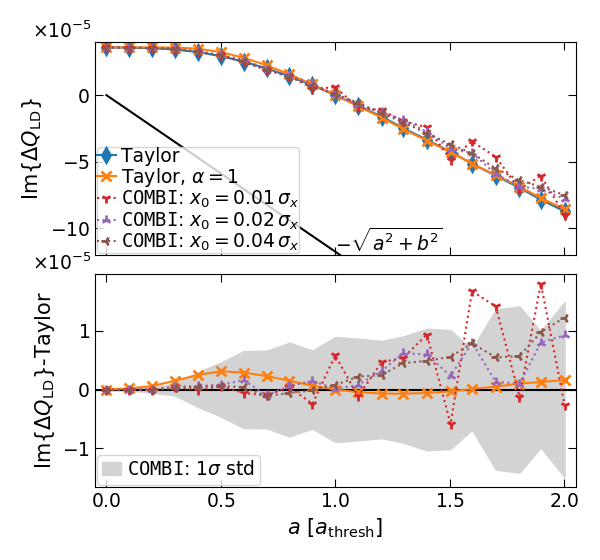

<IPython.core.display.Javascript object>


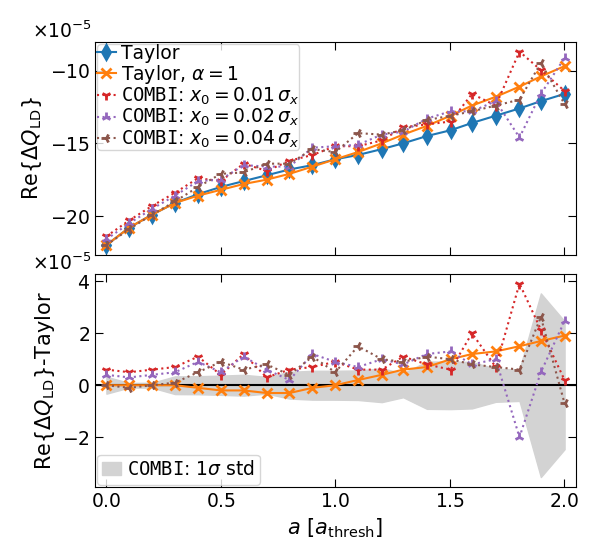

AxesSubplot(0.125,0.53;0.775x0.35)
AxesSubplot(0.125,0.53;0.775x0.35)


In [191]:


# curves = [theory_fa1,theory_fa0,combi_0,combi_2,combi_4]
curves = [theory_thr_fa1,theory_thr_fa0,combi_thr_1,combi_thr_2,combi_thr_4]
curves = [theory_thr_fa1,theory_thr_fa0,theory_thr_DI0,combi_thr_1,combi_thr_2,combi_thr_4]
labels = [r'Taylor',r'Taylor, $\alpha=1$','Transfer function',
          r'$\mathtt{COMBI}$: $x_0=0.01\,\sigma_x$',r'$\mathtt{COMBI}$: $x_0=0.02\,\sigma_x$',r'$\mathtt{COMBI}$: $x_0=0.04\,\sigma_x$']
fmts   = ['-d','-x','-+',':1',':2',':3']

flag_commonError = 1
flag_oneplot = 1




if flag_oneplot:
    fig1,axs = plt.subplots(2,1,sharex=True,figsize=(figwidth,1.4*figheight))
    ax1=axs[0]
    ax2=axs[1]
    
    fig3,axs = plt.subplots(2,1,sharex=True,figsize=(figwidth,1.4*figheight))
    ax3=axs[0]
    ax4=axs[1]
    
    ax2.plot([-1,3],[0,0],'k-')
    ax4.plot([-1,3],[0,0],'k-')
#     ax3.axhline(0,'k')
else:
    fig1=plt.figure()
    ax1=fig1.gca()
    fig2=plt.figure()
    ax2=fig2.gca()
    fig3=plt.figure()
    ax3=fig3.gca()
    fig4=plt.figure()
    ax4=fig4.gca()

for i, curve in enumerate(curves):
    if i in [2]:continue
    ax1.plot(curve[:,0]/a_thr,curve[:,2],fmts[i],c='C%d'%i,ms=7,label=labels[i])
    ax3.plot(curve[:,0]/a_thr,curve[:,1],fmts[i],c='C%d'%i,ms=7,label=labels[i])
    if i>0:
        if i==1 or (flag_commonError):
            ax2.plot(curve[:,0]/a_thr,curve[:,2]-curves[0][:,2],fmts[i],c='C%d'%i,ms=7,label=labels[i])
            ax4.plot(curve[:,0]/a_thr,curve[:,1]-curves[0][:,1],fmts[i],c='C%d'%i,ms=7,label=labels[i])
        else:
            ax2.errorbar(x=curve[:,0]/a_thr,y=curve[:,2]-curves[0][:,2],yerr=curve[:,3],
                         fmt=fmts[i],c='C%d'%i,ms=7,label=labels[i],capsize=3)
            ax4.errorbar(x=curve[:,0]/a_thr,y=curve[:,1]-curves[0][:,1],yerr=curve[:,3],
                         fmt=fmts[i],c='C%d'%i,ms=7,label=labels[i],capsize=3)

# Add estimate of coherent damping
ax1.plot(curve[:,0]/a_thr,-np.sqrt(1+0.7**2)*curve[:,0],'k-')
ax1.annotate(text=r'$-\sqrt{a^2+b^2}$',xy=(1,-10e-5),va='top')
ax1.set_ylim(-12e-5,4e-5)

if flag_commonError:
    errorgr = np.sqrt(np.sum([curves[i][:,3]**2 for i in [5,3,4]],axis=0)) #+combi_2[:,3]**2+combi_4[:,3]**2))
    errorQ  = np.sqrt(np.sum([curves[i][:,4]**2 for i in [5,3,4]],axis=0)) #+combi_2[:,3]**2+combi_4[:,3]**2))
#     error[combi_0[:,3]==0] /=np.sqrt(2)
#     error[combi_0[:,3]>0] /= np.sqrt(3)
    
    
    ax2.fill_between(curves[0][:,0]/a_thr,errorgr,-errorgr,color='lightgray',label=r'$\mathtt{COMBI}$: $1\sigma$ std')
    ax4.fill_between(curves[0][:,0]/a_thr,errorQ ,-errorQ,color='lightgray',label=r'$\mathtt{COMBI}$: $1\sigma$ std')
    
# plt.plot(theory_fa0[:,0],theory_fa0[:,2],':%s'%markers[1],ms=7,label=r'Taylor, $\alpha=1$')
# plt.plot(theory_fa1[:,0],theory_fa1[:,2],':%s'%markers[2],ms=7,label=r'Taylor')
for ia,ax in enumerate([ax1,ax2,ax3,ax4]):
    ax.set_xlabel(r'$a$ $[a_\mathrm{thresh}]$')
    ax.legend(labelspacing=0,borderpad=0,loc=[3,2][ia==2])
    ax.get_yaxis().get_offset_text().set_x(-0.13)
    ax.set_xlim(-0.05,2.05)
    
    #ax.get_yaxis().get_offset_text().set_y(-0.13)  # Does not work...
#     ax.grid(True)

ax1.set_ylabel(r'$\mathrm{Im}\{\Delta Q_\mathrm{LD}\}$')
ax2.set_ylabel(r'$\mathrm{Im}\{\Delta Q_\mathrm{LD}\}$-Taylor')
ax3.set_ylabel(r'$\mathrm{Re}\{\Delta Q_\mathrm{LD}\}$')
ax4.set_ylabel(r'$\mathrm{Re}\{\Delta Q_\mathrm{LD}\}$-Taylor')

if flag_oneplot:
    for i,fig in enumerate([fig1,fig3]):
        ax=[ax1,ax3][i]
        print(ax)
        ax.set_xlabel(None)
        
        ax.ticklabel_format(axis='y',style='sci',scilimits=(-5,-5))
#         ax.yaxis.get_offset_text().set_y(.5)

        fig.tight_layout()
        fig.subplots_adjust(hspace=0.09)
        
        axb=[ax2,ax4][i]
        axb.get_legend().remove()
        if i >=0:
            handles, labels = axb.get_legend_handles_labels()
            axb.legend(handles=[handles[-1]],labels=[labels[-1]],loc=3)
        fig.savefig(pltstorage+'BigOmega_SimVsTaylor_AbsRel_%s.eps'%['Im','Re'][i])

else:
    for i,fig in enumerate([fig1,fig2,fig3,fig4]):
        fig.tight_layout()
        fig.savefig(pltstorage+'BigOmega_SimVsTaylor_%s_%s.eps'%(['Abs','Rel'][i%2],['Im','Re'][i//2]))
    
    
    


<IPython.core.display.Javascript object>


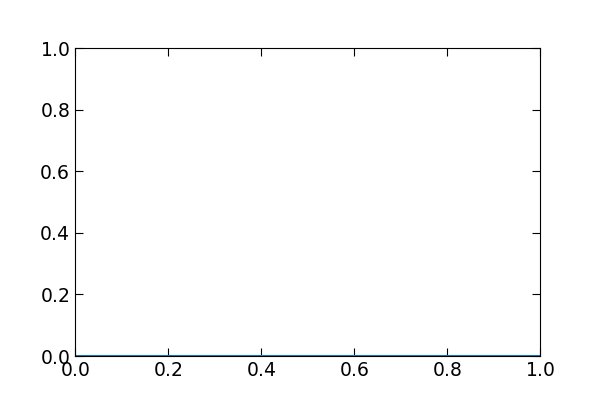

In [192]:
plt.figure()
ax=plt.gca()
ax.axhline(0)

# Unknown

In [100]:
import sys, time, copy
sys.path.append('../')

In [69]:
import numpy as np
import matplotlib.pyplot as plt

from PySSD.Distribution import Distribution,Gaussian
from PySSD.Detuning import LinearDetuning
from PySSD.Dispersion import Dispersion
from PySSD.Integrator import FixedTrapezoidalIntegrator, SimpsonIntegrator, TrapzIntegrator, DblquadIntegrator

#setupQx = 0.31
ax = 3e-5
bx = 0
f_rev = 11.2455e3
Qs = 0.002
Qx=0.31

# Noise 
sigma_ibs=0
D_ibs = f_rev*sigma_ibs**2/2
sigma_k = 1
Pnoise = f_rev*sigma_k**2
D_k = f_rev*sigma_k**2/2

# Modewmode__DQ = [3e-5+1j*2.7e-5]
wmode__DQ = [5e-5+1j*2.86e-5]
# wmode__DQ = [14e-5+1j*0.3e-5]
wmodeQ0 = [Qx]

# PySSD
distribution = Gaussian()
detuning = LinearDetuning(Qx,ax,bx)
integrator = TrapzIntegrator(distribution, detuning, maxJ=18,n_steps=1000)

# Stability diagram parameters
nQ = 60
integrator_epsilon=1e-6 *ax/1e-4 *4
J = np.linspace(3.8,3.9,nQ)
incoQ = Qx*0 + detuning(J,0)

# lebedev
freeQs = J*ax + Qx
cohDQs = np.zeros((len(freeQs)), dtype='complex')
for k, q in enumerate(freeQs):
    cohDQs[k] = (2*integrator.integrate(q,epsilon=integrator_epsilon*1) 
                  -integrator.integrate(q,epsilon=integrator_epsilon*2) )

R = -1/cohDQs
dQ = wmode__DQ

eps =  1+ dQ*R
Dl = D_k *1/np.abs(eps)**2 



# Plotting
plt.figure()
plt.title("Stability diagram and mode")
plt.plot(cohDQs.real,cohDQs.imag)
plt.plot(wmode__DQ[0].real,wmode__DQ[0].imag,'rx')
plt.tight_layout()

plt.figure()
plt.title("Diffusion coefficient")
plt.plot(J,Dl,'r')
plt.xlabel('J')
plt.tight_layout()

ImportError: No module named 'PySSD.Dispersion'